In [1]:
from tqdm import tqdm
import multiprocessing
import gc
from matplotlib import pyplot as plt
import seaborn as sns
import math
import scipy as sc
import sklearn as sk
from random import randint, sample

from numba import jit

from scipy.stats import ks_2samp as ks2
from scipy.stats import mannwhitneyu as mwu
from scipy.stats import wasserstein_distance as w1_dist
from scipy.stats import energy_distance as w2_dist
from scipy.stats import anderson_ksamp as anderson # test if samples are from the same distribution


%load_ext autoreload
%autoreload 2
#%load_ext autoreload

import numpy as np
import pandas as pd
import scipy as sc
from sklearn import decomposition

In [2]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectFdr
from sklearn.feature_selection import SelectFpr

## Shared functions

In [3]:
def _dim_reduction(df= None, y= None, n_comp=50, method='PCA', pc_solver='arpack'):
    # method: PCA
    #print("There are {} features to reduce...woohooo".format(len(gene_columns)))
    ind = df.index
    red_data_dict = {}
    print("Running reducer on all samples..")
    X = df.loc[:, :]
    if method=='PCA':
        reducer = decomposition.PCA(copy= True, n_components= n_comp, svd_solver= pc_solver)
        X_red = reducer.fit_transform(X)
    elif method=='LDA':
        reducer = LDA(n_components= n_comp, solver= 'svd')
        X_red = reducer.fit_transform(X, y)
    
    red_cols = ['red_'+str(i) for i in range(0, n_comp)]
    df_red = pd.DataFrame(data= X_red, index= ind, columns= red_cols)
    
    red_data_dict['ALL'] = {}
    red_data_dict['ALL']['data'] = df_red
    red_data_dict['ALL']['reducer'] = reducer
    
    return red_data_dict

In [4]:
def _distance_significance(x,y, method='MWU'):
    # difference between distributions
    #
    # consider 1st (EMD) and 2nd (Cramer Von Mises) Wasserstein distance --> equal to area between CDF's for 1D distro's
    # consider Kolmogorov-Smirnov
    # consider MW-U
    # consider modified z-scores
    # consider quantiles
    # consider Kruskal Wallis
    # diff per feature, per sample -> expensive
    # scipy.stats import wasserstein_distance
    # scipy.stats import energy_distance
    # Kullback-Leibler divergence, Jensen-Shannon divergence, etc. only works for coupled data
    # Spearman-Rank, Cosine-distance, etc. only works for coupled data or data of the same size.
    
    return True

# significances of differences between pheno's.
def distribution_difference_phenotypes(df, batches=[], phenotypes=[]):
    tot_res = []
    for _phenotype in phenotypes:    
        res = []
        for _batch_nr in batches:
            _all = df.loc[df.batch_number!=_batch_nr][_phenotype]
            _batch = df.loc[df.batch_number==_batch_nr][_phenotype]
            _ks = ks2(_all.values, _batch.values)
            _mwu = mwu(_all.values, _batch.values, alternative='two-sided')
            try:
                _w1 = w1_dist(_all[~np.isnan(_all)], _batch[~np.isnan(_batch)])
                _w2 = w2_dist(_all[~np.isnan(_all)], _batch[~np.isnan(_batch)])
            except ValueError as e:
                print('ValError, defaulting to NaN')
                _w1 = _w2 = np.nan

            res.append({'batch_number': _batch_nr,
                        'ks_stat': _ks[0], 'ks_p': _ks[1],
                        'mwu_stat': _mwu[0], 'mwu_p': _mwu[1],
                        'w1_dist': _w1, 'w2_dist': _w2})
        res_df = pd.DataFrame(res)
        tot_res.append({_phenotype: res_df})
    return tot_res

def _cohort_bias_metrics_colwise_reduced(cohort_dict, one_vs_all = True, equi_size = False):
    '''
     cohort_dict: {cohort_name: {'data': PC's, 'reducer': PCA transformer}}
     one_vs_all: if True, compares each cohort to all other cohorts in bulk, 
                 else compares each cohort to each other cohort separately
    '''
    # Assumes reduction to 3 dimensions..
    # Because the cohorts have different sample sizes we cannot simply do an inter-cohort correlation
    # first we collect them in N columns, with N the number of PC's, then we cut those
    # vectors in M pieces where M is the average number of samples per cohort, then we perform the
    # correlation those artificial cohorts.
    # TO DO: add statistical significance tests..Kruskal-Wallis H Test, MW-U, FDR, KS
    metrics = {}
    cohorts = list(cohort_dict.keys())
    num_cohorts_ = len(cohorts) 
    if one_vs_all==False:
        # avg samples per cohort: M        
        
        if equi_size:
            pc1_matrix = cohort_dict[cohorts[0]]['data'][:,0]
            pc2_matrix = cohort_dict[cohorts[0]]['data'][:,1]
            pc3_matrix = cohort_dict[cohorts[0]]['data'][:,2]            
            for _cohort in cohorts[1:-1]:
                pc1_matrix = np.hstack((pc1_matrix, cohort_dict[_cohort]['data'][:,0]))
                pc2_matrix = np.hstack((pc2_matrix, cohort_dict[_cohort]['data'][:,1]))
                pc3_matrix = np.hstack((pc3_matrix, cohort_dict[_cohort]['data'][:,2]))
            
            len_ = pc1_matrix.shape[0]
            avg_samples = int(np.floor(len_/num_cohorts_))
            tot_num = avg_samples*len(cohorts)
            # cut in M pieces
            masked_ = np.random.randint(len_, size=(len_ - tot_num))
            pc1_matrix_ = np.delete(pc1_matrix, masked_) #np.ma.array(pc1_matrix, mask=False).mask[masked_].compressed()
            pc2_matrix_ = np.delete(pc2_matrix, masked_) #np.ma.array(pc2_matrix, mask=False).mask[masked_].compressed()
            pc3_matrix_ = np.delete(pc3_matrix, masked_) #np.ma.array(pc3_matrix, mask=False).mask[masked_].compressed()
            # reshape
            pc1_matrix_ = pc1_matrix_.reshape((avg_samples, num_cohorts_))
            pc2_matrix_ = pc2_matrix_.reshape((avg_samples, num_cohorts_))
            pc3_matrix_ = pc3_matrix_.reshape((avg_samples, num_cohorts_)) 
            
            pc_matrices = (pc1_matrix_, pc2_matrix_, pc3_matrix_)
                        
            # rank correlation, only works for equisized sets
            metrics['spearman']={}
            metrics['spearman'][0] = spearmanr(pc_matrices[0][:, :], pc_matrices[0][:, :])
            metrics['spearman'][1] = spearmanr(pc_matrices[1][:, :], pc_matrices[1][:, :])
            metrics['spearman'][2] = spearmanr(pc_matrices[2][:, :], pc_matrices[2][:, :])
            # Wasserstein-Distance 1st and 2nd, 
            metrics['wasserstein']={'1st': [np.zeros((num_cohorts_, num_cohorts_)), 
                                            np.zeros((num_cohorts_, num_cohorts_)),
                                            np.zeros((num_cohorts_, num_cohorts_))], 
                                    
                                    '2nd': [np.zeros((num_cohorts_, num_cohorts_)),
                                            np.zeros((num_cohorts_, num_cohorts_)),
                                            np.zeros((num_cohorts_, num_cohorts_))]}   
            
            metrics['significance']={'MW-U': [np.zeros((num_cohorts_, num_cohorts_)), 
                                              np.zeros((num_cohorts_, num_cohorts_)),
                                              np.zeros((num_cohorts_, num_cohorts_))]}   
            for idx,pc_mat in enumerate(pc_matrices):
                for cohort_ind in range(0,num_cohorts_):    
                    for cohort_ind_sec in range(0,cohort_ind):
                        metrics['wasserstein']['1st'][idx][cohort_ind, cohort_ind_sec] = w1_dist(
                                                                          u_values=pc_mat[:, cohort_ind],
                                                                          v_values=pc_mat[:, cohort_ind_sec])
                        
                        metrics['wasserstein']['2nd'][idx][cohort_ind, cohort_ind_sec] = w2_dist(
                                                                          u_values=pc_mat[:, cohort_ind],
                                                                          v_values=pc_mat[:, cohort_ind_sec]) 

                        metrics['significance']['MW-U'][idx][cohort_ind, cohort_ind_sec] = mannwhitneyu(
                                                                          pc_mat[:, cohort_ind],
                                                                          pc_mat[:, cohort_ind_sec])[1]
        else: # non-equisized
            # wasserstein 1/2
            # log 10 of p-values of FDR of each cohort versus other cohorts (only for non-equisized cohorts)
            metrics['wasserstein']={'1st': [np.zeros((num_cohorts_, num_cohorts_)), 
                                            np.zeros((num_cohorts_, num_cohorts_)),
                                            np.zeros((num_cohorts_, num_cohorts_))], 
                                    
                                    '2nd': [np.zeros((num_cohorts_, num_cohorts_)),
                                            np.zeros((num_cohorts_, num_cohorts_)),
                                            np.zeros((num_cohorts_, num_cohorts_))]}      

            metrics['significance']={'MW-U': [np.zeros((num_cohorts_, num_cohorts_)), 
                                              np.zeros((num_cohorts_, num_cohorts_)),
                                              np.zeros((num_cohorts_, num_cohorts_))] }
            for idx in range(0,3):
                for cohort_ind in range(0,num_cohorts_):    
                    for cohort_ind_sec in range(0,cohort_ind):
                        #print("cohort:",cohorts[cohort_ind], "idx:",idx)
                        metrics['wasserstein']['1st'][idx][cohort_ind, cohort_ind_sec] =\
                                    w1_dist(u_values=cohort_dict[cohorts[cohort_ind]]['data'][:, idx],
                                            v_values=cohort_dict[cohorts[cohort_ind_sec]]['data'][:, idx])  
                        
                        metrics['wasserstein']['2nd'][idx][cohort_ind, cohort_ind_sec] =\
                                    w2_dist(u_values=cohort_dict[cohorts[cohort_ind]]['data'][:, idx],
                                            v_values=cohort_dict[cohorts[cohort_ind_sec]]['data'][:, idx])
                        
                        metrics['significance']['MW-U'][idx][cohort_ind, cohort_ind_sec] =\
                                    mannwhitneyu(cohort_dict[cohorts[cohort_ind]]['data'][:, idx],
                                                 cohort_dict[cohorts[cohort_ind_sec]]['data'][:, idx])[1]                        
                        
                        # FDR
                       
    else: # one-vs-all
        # for each cohort compare to the distributions of the rest
        # collect 
        pc1_matrix = cohort_dict[cohorts[0]]['data'][:,0]
        pc2_matrix = cohort_dict[cohorts[0]]['data'][:,1]
        pc3_matrix = cohort_dict[cohorts[0]]['data'][:,2]            
        for _cohort in cohorts[1:-1]:
            pc1_matrix = np.hstack((pc1_matrix, cohort_dict[_cohort]['data'][:,0]))
            pc2_matrix = np.hstack((pc2_matrix, cohort_dict[_cohort]['data'][:,1]))
            pc3_matrix = np.hstack((pc3_matrix, cohort_dict[_cohort]['data'][:,2]))
            
        pc_matrices = (pc1_matrix, pc2_matrix, pc3_matrix)

        metrics['wasserstein']={'1st': [np.zeros((num_cohorts_)), 
                                        np.zeros((num_cohorts_)),
                                        np.zeros((num_cohorts_))], 
                                    
                                '2nd': [np.zeros((num_cohorts_)),
                                        np.zeros((num_cohorts_)),
                                        np.zeros((num_cohorts_))]}     
        metrics['significance']={'MW-U': [np.zeros((num_cohorts_)), 
                                        np.zeros((num_cohorts_)),
                                        np.zeros((num_cohorts_))] }
    
        for idx in range(0,3):
            for cohort_ind in range(0, num_cohorts_):
                metrics['wasserstein']['1st'][idx][cohort_ind]=\
                                w1_dist(u_values=cohort_dict[cohorts[cohort_ind]]['data'][:, idx],
                                        v_values=pc_matrices[idx])
                    
                metrics['wasserstein']['2nd'][idx][cohort_ind] =\
                                w2_dist(u_values=cohort_dict[cohorts[cohort_ind]]['data'][:, idx],
                                        v_values=pc_matrices[idx])
                
                metrics['significance']['MW-U'][idx][cohort_ind]=mannwhitneyu(
                                cohort_dict[cohorts[cohort_ind]]['data'][:, idx],
                                pc_matrices[idx])[1]
    return metrics


In [5]:
#@jit
def median_shift(x, batch_ids):
    '''
     x : dataset 
     batch_ids : dict
    ''' 
    
    delta = np.zeros([x.shape[0], len(batch_ids)])
    for idx, _batch in tqdm(enumerate(batch_ids.keys())):
        median_batch = np.median(x[:, batch_ids[_batch]], axis=1)
        #median_all = np.median(x, axis=1)
        median_all = np.median(np.delete(x, batch_ids[_batch], axis=1), axis=1)
        delta[:,idx] = median_batch - median_all
        
    return delta 

@jit
def mean_shift(x, batch_ids):
    '''
     x : dataset 
     batch_ids : dict
    ''' 
    
    delta = np.zeros([x.shape[0], len(batch_ids)])
    for idx, _batch in tqdm(enumerate(batch_ids.keys())):
        mean_batch = np.mean(x[:, batch_ids[_batch]], axis=1)
        #mean_all = np.mean(x, axis=1)
        mean_all = np.mean(np.delete(x, batch_ids[_batch], axis=1), axis=1)
        delta[:,idx] = mean_batch - mean_all
        
    return delta 

In [6]:
class fs_mannwhitney():
    pvalues_ = None
    scores_ = None
    def __init__(self, pvalue = 0.01, mode='auto'):
        # mode : 'auto', 'exact', 'asymp'
        self.pvalue = pvalue
        self.mode = mode

    def apply_test(self, pos, neg, column):
        zscore, p_value = mwu(pos[:,column], neg[:,column], alternative="two-sided") # mode=self.mode
        return zscore, p_value
    
    def fit(self, x, y):
        zero_idx = np.where(y == 0)[0]
        one_idx = np.where(y == 1)[0]
        pos_samples = x[one_idx]
        neg_samples = x[zero_idx]                
        results_ = np.array(list(map(lambda c: 
            self.apply_test(pos_samples, neg_samples, c), range(0,x.shape[1]))))
        self.scores_ = results_[:, 0]
        self.pvalues_ = results_[:, 1]
        return self

    def transform(self, x):
        not_signif = self.p_values<self.pvalue
        to_delete = [idx for idx, item in enumerate(not_signif) if item == False]
        return np.delete(x, to_delete, axis = 1), to_delete

class fs_ks():
    pvalues_ = None
    scores_ = None
    def __init__(self, pvalue = 0.01):
        self.pvalue = pvalue

    def apply_test(self, pos, neg, column):
        zscore, p_value = ks2(pos[:,column], neg[:,column])
        return zscore, p_value
    
    def fit(self, x, y):
        zero_idx = np.where(y == 0)[0]
        one_idx = np.where(y == 1)[0]
        pos_samples = x[one_idx]
        neg_samples = x[zero_idx]                
        results_ = np.array(list(map(lambda c: 
            self.apply_test(pos_samples, neg_samples, c), range(0,x.shape[1]))))
        self.scores_ = results_[:, 0]
        self.pvalues_ = results_[:, 1]
        return self

    def transform(self, x):
        not_signif = self.p_values<self.pvalue
        to_delete = [idx for idx, item in enumerate(not_signif) if item == False]
        return np.delete(x, to_delete, axis = 1), to_delete
    
class fs_ad():
    pvalues_ = None
    crit_vals = None
    scores_ = None
    
    def __init__(self, pvalue = 0.01):
        self.pvalue = pvalue

    def apply_test(self, samples):
        zscore, crit_val, p_value = anderson(samples)
        return zscore, crit_val, p_value
    
    def fit(self, x):             
        results_ = np.array(list(map(lambda c: 
            self.apply_test(x[:,c].reshape([-1,1])), range(0, x.shape[1]))))
        self.scores_ = results_[:, 0] 
        self.crit_vals = results_[: ,1]
        self.pvalues_ = results_[:, 2]
        return self

    def transform(self, x):
        not_signif = self.p_values<self.pvalue
        to_delete = [idx for idx, item in enumerate(not_signif) if item == False]
        return np.delete(x, to_delete, axis = 1), to_delete
    
class fs_ws1():
    scores_ = None
    def __init__(self, pvalue = 0.01):
        self.pvalue = pvalue

    def apply_test(self, pos, neg, column):
        zscore = w1_dist(pos[:,column], neg[:,column])
        return zscore
    
    def fit(self, x, y):
        zero_idx = np.where(y == 0)[0]
        one_idx = np.where(y == 1)[0]
        pos_samples = x[one_idx]
        neg_samples = x[zero_idx]                
        results_ = np.array(list(map(lambda c: 
            self.apply_test(pos_samples, neg_samples, c), range(0,x.shape[1]))))
        self.scores_ = results_
        return self
    
class fs_ws2():
    scores_ = None
    def __init__(self, pvalue = 0.01):
        self.pvalue = pvalue

    def apply_test(self, pos, neg, column):
        zscore = w2_dist(pos[:,column], neg[:,column])
        return zscore
    
    def fit(self, x, y):
        zero_idx = np.where(y == 0)[0]
        one_idx = np.where(y == 1)[0]
        pos_samples = x[one_idx]
        neg_samples = x[zero_idx]                
        results_ = np.array(list(map(lambda c: 
            self.apply_test(pos_samples, neg_samples, c), range(0,x.shape[1]))))
        self.scores_ = results_
        return self
    
    
def get_filtered_genomes(x, y, Rclass = None):
    try:
        alpha = Rclass.PIPELINE_PARAMETERS['feature_selection']['pvalue']
        filter_type = Rclass.PIPELINE_PARAMETERS['feature_selection']['method']
        F_function =  Rclass.PIPELINE_PARAMETERS['feature_selection']['score_function']
    except Exception as e:
        print("Exception with {} handling the function get_filtered_genomes".format(e))
        alpha = 0.05
        filter_type = 'FDR'
        F_function = 'ANOVA'    
    
    #  Mann-Whitney, between classes
    # scipy.stats.mannwhitneyu, https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html
    if filter_type == 'mannwhitney':
        Selector = fs_mannwhitney(pvalue = alpha).fit(x,y)
        x_out = Selector.transform(x)[0]
    elif filter_type == 'FDR':
    # Use FDR with a number of different statistical measures:
    # f_classif, chi2, 
        FDR_function = f_classif if F_function == 'ANOVA' else eval(F_function)
        FDR = SelectFdr(alpha = alpha, score_func = FDR_function) #f_classif, chi2
        Selector = FDR.fit(x, y)
        x_out = FDR.transform(x)
    elif filter_type == 'FPR':
        FPR_function = f_classif if F_function == 'ANOVA' else eval(F_function)
        FPR = SelectFpr(alpha = alpha, score_func = FPR_function) #f_classif, chi2
        Selector = FPR.fit(x, y)
        x_out = FPR.transform(x)        

    return x_out, Selector

#@jit('int32[:](float64[:,:], int32[:]))
def get_differential_probes(x, y, method='FDR', alpha=0.05, **kwargs):
    '''
     x : array (samples x probes)
     y : array (target values)
     method : FDR/MWU/KS 
     n_top : number of top discriminating probes 
     kwargs: arguments for stat method
     
     return: index array of top n discriminators
    '''
        
    idx = x.columns
    if method=='FDR':
        F_function = 'ANOVA'
        FDR_function = f_classif if F_function == 'ANOVA' else eval(F_function)
        FDR = SelectFdr(FDR_function, alpha = alpha) #f_classif, chi2
        selector = FDR.fit(x, y)
    elif method=='FPR':
        F_function = 'ANOVA'
        FPR_function = f_classif if F_function == 'ANOVA' else eval(F_function)
        FPR = SelectFdr(FPR_function, alpha = alpha) #f_classif, chi2
        selector = FPR.fit(x, y)      
    elif method=='MWU':
        selector = fs_mannwhitney(pvalue = alpha).fit(x.values,y)
    elif method=='KS':
        selector = fs_ks(pvalue = alpha).fit(x.values,y)
    elif method=='AD':
        selector = fs_ad().fit(x.values) 
    elif method=='WASS1':
        selector = fs_ws1().fit(x.values, y)
    elif method=='WASS2':
        selector = fs_ws2().fit(x.values, y)
    if method in ['WASS1', 'WASS2']:
        return pd.DataFrame(data=selector.scores_.T, 
                        columns=['score_'+method],
                        index=idx)
    else:
        return pd.DataFrame(data=np.vstack((selector.pvalues_, selector.scores_)).T, 
                        columns=['pvals_'+method, 'score_'+method],
                        index=idx)

## Load data
Due to resources limitations we analysis one methylation set at a time. 

In [7]:
MethylationForm = 'beta' # 'beta', 'M'

In [8]:
# "/media/koekiemonster/DATA-FAST/genetic_expression/hackathon_2/Lung"
# "/home/bramiozo/DATA/LungCancerResearch/" 
source_dir = "/media/koekiemonster/DATA-FAST/genetic_expression/hackathon_2/Lung/"

# _prepped/methylation_Mvalues.csv Lung_Methylation.txt
Meth_Raw = pd.read_csv(source_dir+"Lung_Methylation.txt", sep="\t", engine="python")

Meth_Raw.set_index('probeID', inplace=True)
GeneMapping = Meth_Raw[['Chr', 'Start', 'Stop', 'Strand', 'Gene', 'Relation_CpG_Island']]
Meth_Raw.drop(['Chr', 'Start', 'Stop', 'Strand', 'Gene', 'Relation_CpG_Island'], inplace=True, axis=1)



In [ ]:
if MethylationForm=='M':
    offset = 1e-3
    def Mtransform(x):
        try:
            return np.log2((x+offset)/(1-x+offset))
        except ValueError:
            return np.nan

    pat_cols = [_col for _col in methylation.columns if "TCGA" in _col]    
    Meth_Raw = Meth_Raw.copy().loc[:, pat_cols].progress_apply(Mtransform, axis=0)
    gc.collect()

In [9]:
pheno_small = pd.read_csv("../../_docs/Lung_Phenotype_Metadata.txt", sep="\t")
pheno_small = pheno_small.copy().loc[pheno_small["Sample Type"]=='Primary Tumor']
pheno_small.set_index('SampleID', inplace=True)
pheno_large = pd.read_csv("../../_docs/Lung_Table_Phenotypes.txt", sep="\t")
pheno_large.set_index('submitter_id.samples', inplace=True)
pheno_large['SampleID'] = pheno_large.index
pheno_large = pheno_large.copy().loc[pheno_large["sample_type.samples"]=='Primary Tumor']

In [12]:
methylation_meta = pd.read_csv(source_dir+"HumanMethylation450_meta.csv", sep=",", engine="python", skiprows=7)

In [10]:
# Gender (small) Pack Years (small), Smoking Status (small), Diagnosis (small), Age At Diagnosis (Days) (small)
# batch_number (large), histological_type (large), cigarettes_per_day.exposures (large), tissue_or_organ_of_origin.diagnoses (large)
# race.demographic
pheno = pheno_small[['Gender', 'Pack Years', 'Smoking Status', 'Diagnosis', 'Age At Diagnosis (Days)']]\
                    .merge(pheno_large[['batch_number', 'histological_type', 'cigarettes_per_day.exposures',
                                       'tissue_or_organ_of_origin.diagnoses', 'race.demographic']], how='inner',
                                       left_index=True, right_index=True)

In [11]:
# split by diagnosis
LA_samples = pheno.loc[pheno.Diagnosis=='Lung Adenocarcinoma'].index.values
LSCC_samples = pheno.loc[pheno.Diagnosis=='Lung Squamous Cell Carcinoma'].index.values

In [12]:
# to check for cohort bias we only use the reference probe initially
gc.collect()  

107

In [13]:
Meth_data = {'LA': Meth_Raw.loc[:, LA_samples],
             'LSCC': Meth_Raw.loc[:, LSCC_samples]}
del Meth_Raw

gc.collect()

Meth_data_T = {'LA': Meth_data['LA'].T, 
               'LSCC': Meth_data['LSCC'].T}

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


### Seperability of cohorts

In [14]:
def _clean(df, complete=True):
    drop_rows = df[df.isna().sum(axis=1)>450000].index.tolist()
    drop_cols = df.columns[df.isna().sum(axis=0)>400].tolist()
    print("We drop {} samples and {} probes".format(len(drop_rows), len(drop_cols)))
    df_out = df.copy().drop(drop_rows, axis=0).drop(drop_cols, axis=1)
    if complete:
        drop_cols = df_out.copy().columns[df_out.copy().isna().sum(axis=0)>0].tolist()
        df_out = df_out.copy().drop(drop_cols, axis=1)
    initial_points = df.shape[0]*df.shape[1]
    removed = (initial_points - df_out.shape[0]*df_out.shape[1])
    print("Removed {} points from an initial {} points".format(removed, initial_points))
    return df_out

In [125]:
_cleaned_LA = _clean(Meth_data_T['LA'])
_cleaned_LSCC = _clean(Meth_data_T['LSCC'])

We drop 0 samples and 0 probes
Removed 12237684 points from an initial 194467915 points
We drop 134 samples and 89512 probes
Removed 103868270 points from an initial 246187539 points


In [436]:
tot_na = Meth_data['LA'].isna().sum().sum() + Meth_data['LSCC'].isna().sum().sum()
tot_points = Meth_data['LA'].size + Meth_data['LSCC'].size
print("Total number of NA's:", tot_na)
print("Total number of datapoints:", tot_points)
print("NA percentage:", tot_na/tot_points)

Total number of NA's: 174262840
Total number of datapoints: 516168351
NA percentage: 0.3376085334608204


In [15]:
_cleaned_ALL = _clean(pd.concat([Meth_data_T['LA'], Meth_data_T['LSCC']]))

We drop 199 samples and 89841 probes
Removed 200133567 points from an initial 516168351 points


Text(0,0.5,'# affected samples')

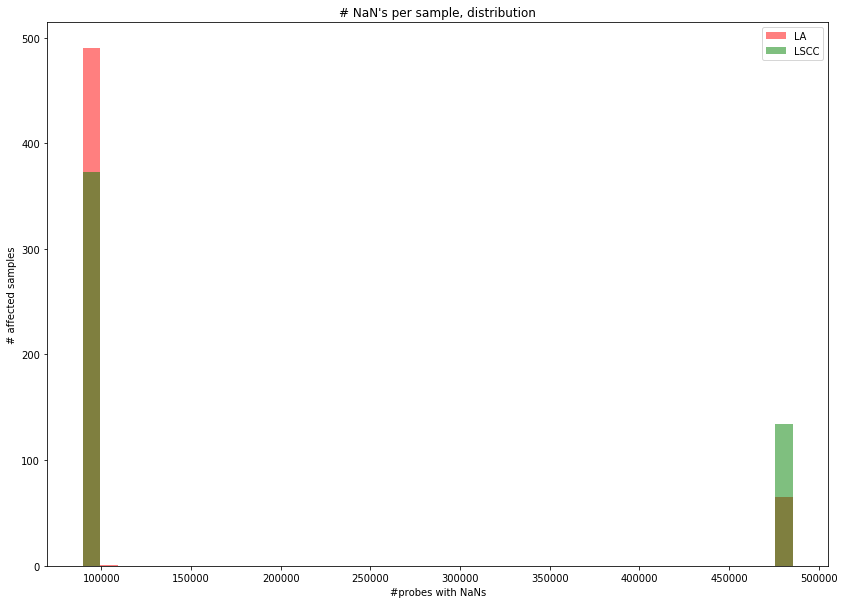

In [479]:
fig, ax = plt.subplots(figsize=(14,10))
ax.hist(x=Meth_data['LA'].isna().sum(axis=0).values, bins=40, color=['red'], stacked=True, label='LA', alpha=0.5)
ax.hist(x=Meth_data['LSCC'].isna().sum(axis=0).values, bins=40, color=['green'], stacked=True, label='LSCC', 
            alpha=0.5)

plt.legend()
plt.title("# NaN's per sample, distribution")
plt.xlabel('#probes with NaNs')
plt.ylabel('# affected samples')

Text(0,0.5,'# affected probes')

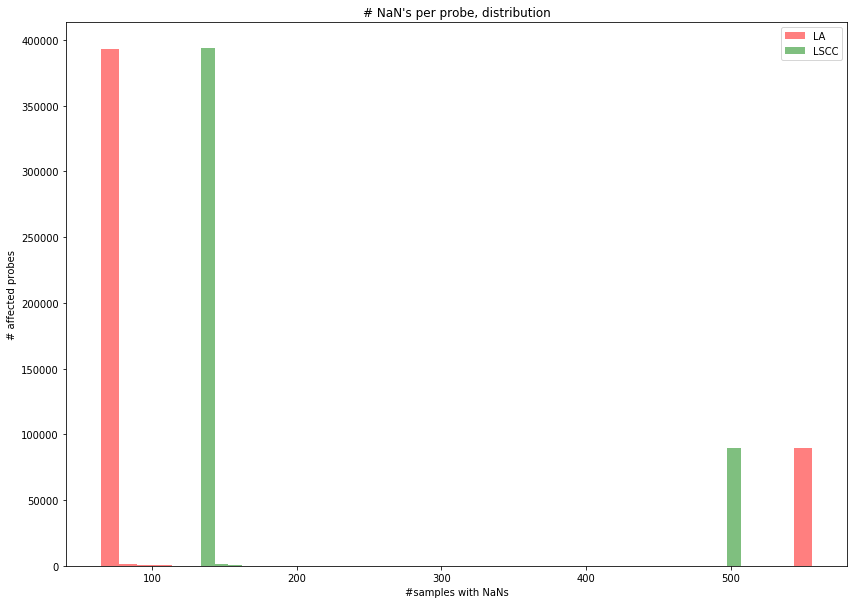

In [480]:
fig, ax = plt.subplots(figsize=(14,10))
ax.hist(x=Meth_data['LA'].isna().sum(axis=1).values, bins=40, color=['red'], stacked=True, label='LA', alpha=0.5)
ax.hist(x=Meth_data['LSCC'].isna().sum(axis=1).values, bins=40, color=['green'], stacked=True, label='LSCC', alpha=0.5)
plt.legend()
plt.title("# NaN's per probe, distribution")
plt.xlabel('#samples with NaNs')
plt.ylabel('# affected probes')

** I.e. About 130 samples exclusively have NaN's ** 

** I.e. practically all of the samples of the Adenocarcinoma and Squamous Cell carcinoma sets have about 80.000 probes with NaN's ** 

In [15]:
del Meth_data_T
gc.collect()

21

In [106]:
gc.collect()
data_reduced = {}
data_reduced['LA'] = _dim_reduction(_cleaned_LA, min_samples=10, n_comp=50, method='PCA', pc_solver='arpack')
data_reduced['LSCC'] = _dim_reduction(_cleaned_LSCC, min_samples=10, n_comp=50, method='PCA', pc_solver='arpack')

We drop 0 samples and 0 probes
Running reducer on all samples..
We drop 134 samples and 89512 probes
Running reducer on all samples..


In [42]:
data_reduced['ALL'] = _dim_reduction(_cleaned_ALL, min_samples=10, n_comp=50, method='PCA', pc_solver='arpack')

Running reducer on all samples..


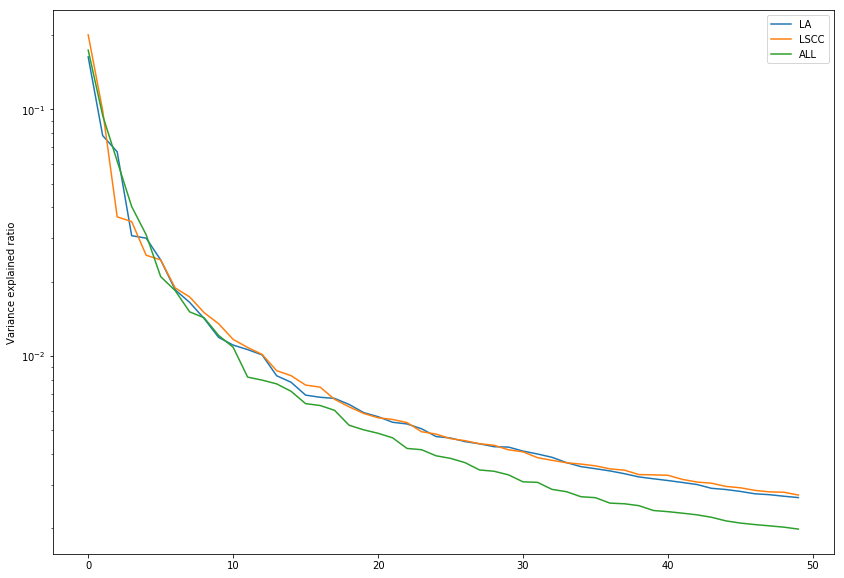

In [44]:
fig, ax = plt.subplots(figsize=(14,10))
for _key in data_reduced.keys():
    plt.plot(data_reduced[_key]['ALL']['reducer'].explained_variance_ratio_, label=_key)
    plt.semilogy()
    plt.ylabel('Variance explained ratio')
    plt.legend()

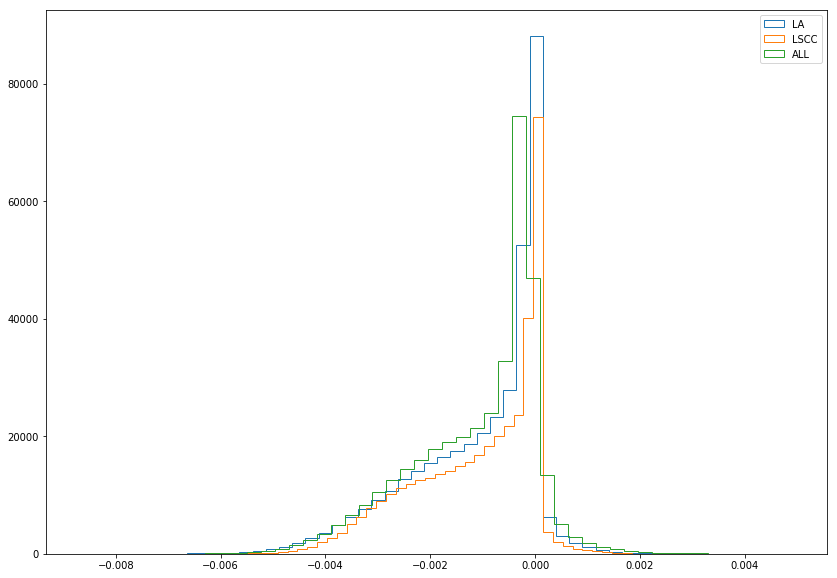

In [45]:
fig, ax = plt.subplots(figsize=(14,10))
plt.hist(data_reduced['LA']['ALL']['reducer'].components_[0], bins=50, histtype='step', label='LA');
plt.hist(data_reduced['LSCC']['ALL']['reducer'].components_[0], bins=50, histtype='step', label='LSCC');
plt.hist(data_reduced['ALL']['ALL']['reducer'].components_[0], bins=50, histtype='step', label='ALL');
plt.legend()

In [46]:
_filter= (data_reduced['ALL']['ALL']['reducer'].components_[0]>0.001) | \
         (data_reduced['ALL']['ALL']['reducer'].components_[0]<-0.004)
pca_0_idx = np.argwhere(_filter)
Genes = _cleaned_ALL.columns[pca_0_idx]
print("Important genes are for the first principal component: \n {}".format(Genes))

Important genes are for the first principal component: 
 Index(['cg00003529', 'cg00006626', 'cg00009001', 'cg00009553', 'cg00011225',
       'cg00011616', 'cg00012529', 'cg00012698', 'cg00013015', 'cg00013899',
       ...
       'cg27649037', 'cg27652681', 'cg27656184', 'cg27657333', 'cg27658601',
       'cg27660720', 'cg27663936', 'cg27664085', 'cg27666123', 'rs7746156'],
      dtype='object', name='probeID', length=12312)


In [214]:
# top 100 probes
N = 10
top_N_pc0 = np.argsort(np.abs(data_reduced['ALL']['ALL']['reducer'].components_[0]))[-N:]
top_N_pc1 = np.argsort(np.abs(data_reduced['ALL']['ALL']['reducer'].components_[1]))[-N:]
top_N_pc2 = np.argsort(np.abs(data_reduced['ALL']['ALL']['reducer'].components_[2]))[-N:]
Top_N_Probes_PC0 = _cleaned_ALL.columns[top_N_pc0]
Top_N_Probes_PC1 = _cleaned_ALL.columns[top_N_pc1]
Top_N_Probes_PC2 = _cleaned_ALL.columns[top_N_pc2]

In [16]:
tmp = _cleaned_ALL.merge(pheno[~pheno.index.duplicated()]['Diagnosis'], how='left', left_index=True, right_index=True)
y = tmp.Diagnosis.apply(lambda x: 0 if x=='Lung Adenocarcinoma' else 1).values
x = tmp.drop('Diagnosis', axis=1)
del tmp
gc.collect()

56

In [49]:
ALL_LDA = _dim_reduction(x, y, n_comp=1, method='LDA')

Running reducer on all samples..


/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


In [47]:
N = 500 
top_N_lda = np.argsort(ALL_LDA['ALL']['reducer'].coef_)[0][-N:]
Top_N_Probes_LDA = _cleaned_ALL.columns[top_N_lda]

In [51]:
LDA_scores = pd.DataFrame(data=ALL_LDA['ALL']['reducer'].coef_.reshape([-1,1]), 
                          index=_cleaned_ALL.columns, 
                          columns=['LDA_score'])

In [217]:
GeneCount = pd.DataFrame(GeneMapping.groupby('Gene').size().sort_values(ascending=False), columns=['tot_count'])
GeneOccurrencePC0 = pd.DataFrame(GeneMapping.loc[Top_N_Probes_PC0,:].groupby('Gene').size().sort_values(ascending=False),
                              columns=['occurrence_pc0'])
GeneOccurrencePC1 = pd.DataFrame(GeneMapping.loc[Top_N_Probes_PC1,:].groupby('Gene').size().sort_values(ascending=False),
                              columns=['occurrence_pc1'])
GeneOccurrencePC2 = pd.DataFrame(GeneMapping.loc[Top_N_Probes_PC2,:].groupby('Gene').size().sort_values(ascending=False),
                              columns=['occurrence_pc2'])
GeneOccurrenceLDA = pd.DataFrame(GeneMapping.loc[Top_N_Probes_LDA,:].groupby('Gene').size().sort_values(ascending=False),
                              columns=['occurrence_lda'])
GeneOccurrence = pd.concat([GeneOccurrencePC0, GeneOccurrencePC1, GeneOccurrencePC2, GeneOccurrenceLDA], 
                           axis=1)
GeneOccurrence['tot_count'] = GeneOccurrence.apply(lambda x: np.sum(x), axis=1).sort_values(ascending=False)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # This is added back by InteractiveShellApp.init_path()


In [135]:
pheno.columns

Index(['Gender', 'Pack Years', 'Smoking Status', 'Diagnosis',
       'Age At Diagnosis (Days)', 'batch_number', 'histological_type',
       'cigarettes_per_day.exposures', 'tissue_or_organ_of_origin.diagnoses',
       'race.demographic'],
      dtype='object')

In [155]:
# Clustering of cohorts
data_reduced['LA']['ALL']['data'] = data_reduced['LA']['ALL']['data'][~data_reduced['LA']['ALL']['data'].index.duplicated(keep='first')]
data_reduced['LSCC']['ALL']['data'] = data_reduced['LSCC']['ALL']['data'][~data_reduced['LSCC']['ALL']['data'].index.duplicated(keep='first')]

merged_LA_reduced = data_reduced['LA']['ALL']['data'].merge(pheno, how='left', left_index=True, right_index=True)
merged_LSCC_reduced = data_reduced['LSCC']['ALL']['data'].merge(pheno, how='left', left_index=True, right_index=True)

Text(0.5,0.98,'Mean methylation PC values per cohort')

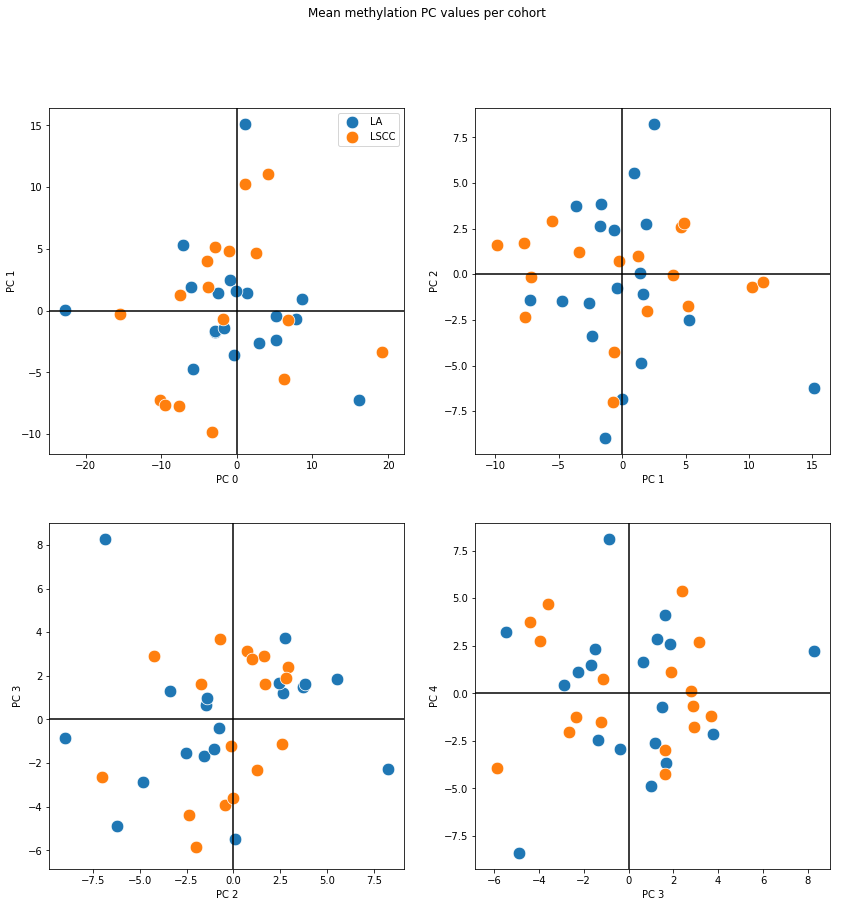

In [210]:
red_cols = [_col for _col in merged_LA_reduced.columns if 'red_' in _col]
red_cols += ['batch_number'] 
plot_LA = merged_LA_reduced[red_cols].groupby('batch_number').mean()

red_cols = [_col for _col in merged_LA_reduced.columns if 'red_' in _col]
red_cols += ['batch_number'] 
plot_LSCC = merged_LSCC_reduced[red_cols].groupby('batch_number').mean()

fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(14,14))
sns.scatterplot(data=plot_LA, x='red_0', y='red_1', s=160, label='LA', ax=ax[0,0])
sns.scatterplot(data=plot_LSCC, x='red_0', y='red_1', s=160, label='LSCC', ax=ax[0,0])
ax[0,0].set_xlabel('PC 0')
ax[0,0].set_ylabel('PC 1')
ax[0,0].legend()
ax[0,0].axvline(0, color='black')
ax[0,0].axhline(0, color='black')

sns.scatterplot(data=plot_LA, x='red_1', y='red_2', s=160, ax=ax[0,1])
sns.scatterplot(data=plot_LSCC, x='red_1', y='red_2', s=160, ax=ax[0,1])
ax[0,1].set_xlabel('PC 1')
ax[0,1].set_ylabel('PC 2')
ax[0,1].axvline(0, color='black')
ax[0,1].axhline(0, color='black')

sns.scatterplot(data=plot_LA, x='red_2', y='red_3', s=160, ax=ax[1,0])
sns.scatterplot(data=plot_LSCC, x='red_2', y='red_3', s=160, ax=ax[1,0])
ax[1,0].set_xlabel('PC 2')
ax[1,0].set_ylabel('PC 3')
ax[1,0].axvline(0, color='black')
ax[1,0].axhline(0, color='black')

sns.scatterplot(data=plot_LA, x='red_3', y='red_4', s=160, ax=ax[1,1])
sns.scatterplot(data=plot_LSCC, x='red_3', y='red_4', s=160, ax=ax[1,1])
ax[1,1].set_xlabel('PC 3')
ax[1,1].set_ylabel('PC 4')
ax[1,1].axvline(0, color='black')
ax[1,1].axhline(0, color='black')


plt.suptitle('Mean methylation PC values per cohort')

The cohort means for the first principle components are distributed around the origin, so assuming an equal sample contribution per cohort the overall 
effect is likely diffuse.


# Batch seperability

In [190]:
data_reduced['LA']['ALL']['data'] = merged_LA_reduced
data_reduced['LSCC']['ALL']['data'] = merged_LSCC_reduced

Processing ds: LA
Processing ds: LSCC


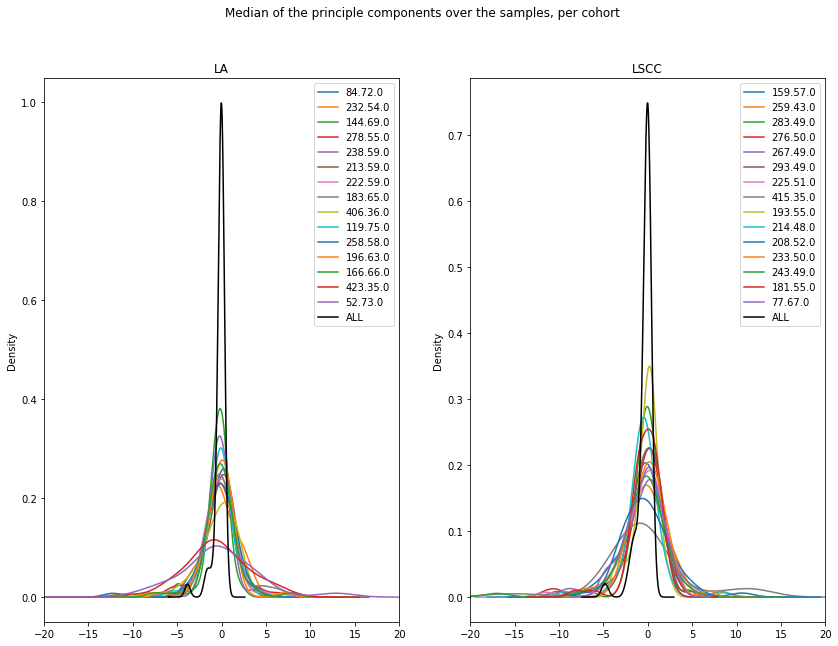

In [24]:
num_test_batches = 15
test_batches = {}

num_of_batches=data_reduced['LA']['ALL']['data']['batch_number'].nunique()
batches = data_reduced['LA']['ALL']['data']['batch_number'].unique()
batch_indices = sample(range(0, num_of_batches), num_test_batches)
test_batches['LA'] = batches[batch_indices].tolist()

num_of_batches=data_reduced['LSCC']['ALL']['data']['batch_number'].nunique()
batches = data_reduced['LSCC']['ALL']['data']['batch_number'].unique()
batch_indices = sample(range(0, num_of_batches), num_test_batches)
test_batches['LSCC'] = batches[batch_indices].tolist()

axc = 0 # 0: distribution of the mean probe values over the samples, 1: mean sample values over the probes
xr = -20, 20
fig, ax = plt.subplots(ncols=2, figsize=(14,10))
for rdx, _dkey in enumerate(data_reduced.keys()):   
    print("Processing ds: {}".format(_dkey))
    for cdx, _batch in enumerate(test_batches[_dkey]):
        #print('Batch: {}'.format(_batch))
        Red_columns = [_col for _col in data_reduced[_dkey]['ALL']['data'].columns if 'red_' in _col]
        data_reduced[_dkey]['ALL']['data'].query('batch_number=="'+str(_batch)+'"').loc[:,Red_columns]\
                                                                     .median(axis=axc).plot.kde(label=_batch, 
                                                                                              ax=ax[rdx])            
    
    data_reduced[_dkey]['ALL']['data'].loc[:,Red_columns].median(axis=0).plot.kde(label='ALL', color='black', ax=ax[rdx])
    ax[rdx].set_xlim(xr[0], xr[1])
    ax[rdx].set_title(_dkey)
    ax[rdx].legend()
    fig.suptitle('Median of the principle components over the samples, per cohort')

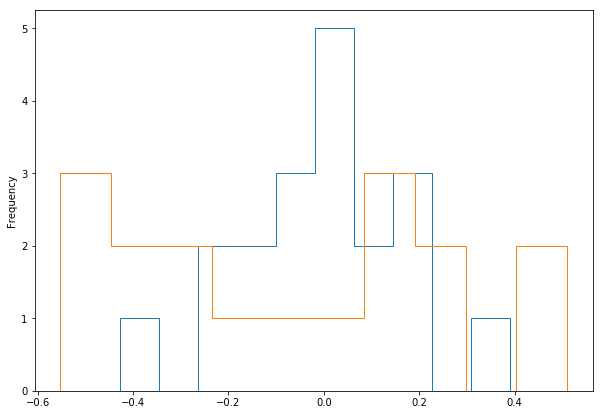

In [28]:
cols = Red_columns+['batch_number']
data_reduced['LA']['ALL']['data'].loc[:,cols].groupby('batch_number').mean().mean(axis=1).plot.hist(histtype='step', label='LA', figsize=(10,7))
data_reduced['LSCC']['ALL']['data'].loc[:,cols].groupby('batch_number').mean().mean(axis=1).plot.hist(histtype='step', label='LSCC')

In [ ]:
# Wasserstein distance internal: distance between samples and median of samples
#w1_dist(vi, vm)
#w2_dist(vi, vm)

# Wasserstein distance external: distance between median of samples and mean of median of cohorts
#w1_dist(vm, vmm)
#w2_dist(vm, vmm)

# Differential methylation between LA and LSCC


In [24]:
# KS, MW-U, FDR
gc.collect()
tmp = _cleaned_ALL.merge(pheno[~pheno.index.duplicated()]['Diagnosis'], how='left', left_index=True, right_index=True)
y = tmp.Diagnosis.apply(lambda x: 0 if x=='Lung Adenocarcinoma' else 1).values
x = tmp.drop('Diagnosis', axis=1)
del tmp 
gc.collect()

35

In [28]:
probes_diffs = {}
probes_diffs['FDR'] = get_differential_probes(x, y, method='FDR', alpha=0.05) # FDR, FPR, KS, MWU

In [84]:
probes_diffs['MWU'] = get_differential_probes(x, y, method='MWU', alpha=0.05) # FDR, FPR, KS, MWU

In [29]:
probes_diffs['KS'] = get_differential_probes(x, y, method='KS', alpha=0.05, mode='exact') # FDR, FPR, KS, MWU

In [ ]:
#probes_diffs['AD'] = get_differential_probes(x, y, method='AD', alpha=0.05) # FDR, FPR, KS, MW

In [31]:
probes_diffs['WASS1'] = get_differential_probes(x, y, method='WASS1') 
probes_diffs['WASS2'] = get_differential_probes(x, y, method='WASS1') 

In [33]:
top_probes = {}
for _key in probes_diffs.keys():    
    q=probes_diffs[_key].score.quantile(0.95)
    probes_diffs[_key]['score'] =  probes_diffs[_key]['score'].abs()
    top_probes[_key] = probes_diffs[_key].query("score>"+str(q)).sort_values('score', ascending=False)
    top_probes[_key] = top_probes[_key].copy().merge(GeneMapping, left_index=True, right_index=True, how='left')

In [407]:
#top_probes[_key].loc[top_probes[_key].Gene.isin(['BRAF', 'MAP2K1', 'KRAS', 'MET', 'RET', 'ROS1', 'EGFR', 'TP53']),:]
#top_probes[_key].loc[top_probes[_key].Gene.isin(['KRT5', 'DSC3', 'DSG3', 'TP63', 'MIR205HG', 'CALML3']),:]

FDR/FPR: 
```BRAF```, ```MAP2K1``` are present which were not differentially expressed in RNA, but not ```KRT5```, ```DSC3```, ```DSG3```, ```TP63```, ```MIR205HG```, ```CALML3``` which **were** strongly differential for the RNA expression.
Other genes we might expect are: ```KRAS```, ```MET```, ```RET```, ```ROS1```, ```EGFR```, ```TP53```. 

MWU: Only ```MAP2K1``` is present.

KS: ```MAP2K1``` of the important general cancer genes.  ```CALML3``` and ```TP63``` of the differential RNA expression genes.

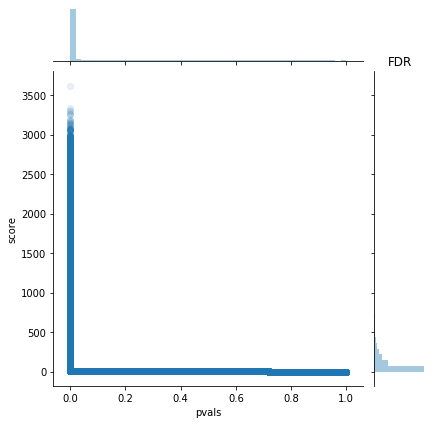

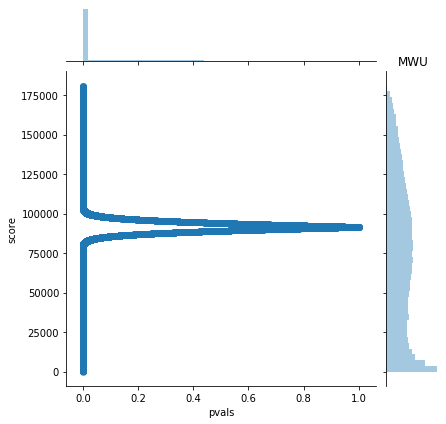

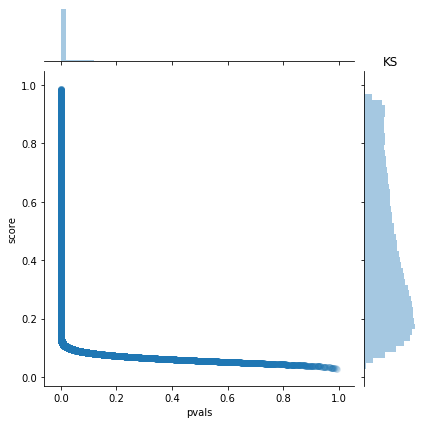

In [35]:
#fig, ax = plt.subplots(figsize=(16,10), ncols=3)
for idx, _key in enumerate(probes_diffs.keys()):
    if _key in['AD', 'WASS1', 'WASS2']:
        break
    sns.jointplot(x='pvals', y='score', data=probes_diffs[_key], alpha=0.1)
    plt.title(_key)

# Get fold change

In [18]:
fc_set = _cleaned_ALL.merge(pheno[~pheno.index.duplicated()]['Diagnosis'], how='left', left_index=True, right_index=True)
fc_set['target'] = fc_set.Diagnosis.apply(lambda x: 0 if x=='Lung Adenocarcinoma' else 1)
fc_set.drop('Diagnosis', axis=1, inplace=True)

In [19]:
abs_fc = (fc_set.query('target==1').mean(axis=0) - fc_set.query('target==0').mean(axis=0))
rel_fc = (fc_set.query('target==1').mean(axis=0) - fc_set.query('target==0').mean(axis=0))/fc_set.query('target==0').mean(axis=0)
abs_fc_median = (fc_set.query('target==1').median(axis=0) - fc_set.query('target==0').median(axis=0))
split_fc = (fc_set.query('target==1').median(axis=0)+fc_set.query('target==0').median(axis=0))/2

In [20]:
abs_fc_df = pd.DataFrame(abs_fc, columns=['abs_fc'])
rel_fc_df = pd.DataFrame(rel_fc, columns=['rel_fc'])
abs_fc_median_df = pd.DataFrame(abs_fc_median, columns=['abs_fc_median'])
split_fc_df = pd.DataFrame(split_fc, columns=['split_fc'])

In [21]:
fc = pd.concat([abs_fc_df, rel_fc_df, abs_fc_median_df, split_fc_df], axis=1)
fc.drop('target', axis=0, inplace=True)

In [59]:
top_fc = pd.concat([fc.sort_values(by='rel_fc', ascending=False)[:2500],
           fc.sort_values(by='rel_fc', ascending=True)[:2500]],
          axis=0)
top_fc = top_fc.copy().merge(GeneMapping, left_index=True, right_index=True, how='left')

In [60]:
# top cancer genomes (RNA expression)
top_fc.loc[top_fc.Gene.isin(['BRAF', 'MAP2K1', 'KRAS', 'MET', 'RET', 'ROS1', 'EGFR', 'TP53']),:]

,abs_fc,rel_fc,abs_fc_median,Chr,Start,Stop,Strand,Gene,Relation_CpG_Island
cg13412066,0.032775,0.795152,-0.0081,chr12,25385359.0,25385361.0,+,KRAS,Island
cg11986813,0.106162,0.718668,-0.0010,chr10,42933695.0,42933697.0,+,RET,Island
cg17339505,-0.066440,-0.734920,-0.0109,chr10,43077172.0,43077174.0,-,RET,NaN
cg05621401,-0.085357,-0.719071,-0.0222,chr10,43076616.0,43076618.0,-,RET,NaN


In [61]:
# top differentials (RNA expression)
top_fc.loc[top_fc.Gene.isin(['KRT5', 'DSC3', 'DSG3', 'TP63', 'MIR205HG', 'CALML3']),:]

,abs_fc,rel_fc,abs_fc_median,Chr,Start,Stop,Strand,Gene,Relation_CpG_Island
cg25789861,-0.164771,-0.804997,-0.1232,chr18,31042973.0,31042975.0,-,DSC3,NaN
cg26861703,-0.160846,-0.798715,-0.1174,chr18,31042951.0,31042953.0,-,DSC3,NaN
cg11722699,-0.139509,-0.774068,-0.0999,chr18,31042846.0,31042848.0,+,DSC3,NaN
cg06263193,-0.142528,-0.763058,-0.0989,chr18,31042945.0,31042947.0,-,DSC3,NaN
cg03017520,-0.256576,-0.752412,-0.2412,chr18,31043123.0,31043125.0,-,DSC3,NaN
cg25970832,-0.249926,-0.738068,-0.3008,chr18,31041684.0,31041686.0,+,DSC3,NaN
cg14719951,-0.252030,-0.721429,-0.2972,chr18,31042507.0,31042509.0,-,DSC3,NaN
cg19967492,-0.197262,-0.695794,-0.2031,chr18,31042233.0,31042235.0,+,DSC3,NaN
cg21393051,-0.252900,-0.695713,-0.2696,chr1,209411964.0,209411966.0,-,MIR205HG,NaN
cg11814235,-0.320996,-0.688125,-0.3652,chr18,31041523.0,31041525.0,+,DSC3,NaN


Of the differentially expressed RNA only ```DSC3``` and ```MIR205HG``` are present in the top 5000 of fold-changes.
Of the important cancer genes only ```RET``` and ```KRAS``` is present.

In [62]:
top_genes_from_meth = ['ARHGEF16', 'AKR7A2', 'LRRC59', 'WFDC2', 'PSRC1', 'NEK9','RUVBL1', 
                       'COL6A4P2', 'MYO1C', 'PCDHGB5', 'RAPGEFL1', 'PAX6', 'PPP2R2C', 'GPR133', 'EN1', 'PRDM16', 
                       'PTH2R', 'CLEC2L', 'RPS4Y1', 'DDX43', 'TDRD1', 'CALML3']

In [63]:
print("Sep:", top_probes['KS'].loc[top_probes['KS'].Gene.isin(top_genes_from_meth),:]['Gene'].unique())

print("FC:", top_fc.loc[top_fc.Gene.isin(top_genes_from_meth),:]['Gene'].unique())

print("+"*50)

Sep: ['RUVBL1' 'WFDC2' 'ARHGEF16' 'MYO1C' 'LRRC59' 'NEK9' 'AKR7A2']
FC: ['RAPGEFL1' 'PAX6' 'EN1' 'PRDM16' 'PPP2R2C']
++++++++++++++++++++++++++++++++++++++++++++++++++


## Induced differentiability due to imputance ?

In [67]:
LA_nans = Meth_data['LA'].isna().sum(axis=1)
LSCC_nans = Meth_data['LSCC'].isna().sum(axis=1)

LA_nan_list = LA_nans[np.where(LA_nans>200)[0]].index.tolist()
LSCC_nan_list = LSCC_nans[np.where(LSCC_nans>200)[0]].index.tolist()

In [68]:
print("\t\tIn the LA set we have {} probes that are NaN for all probes, \n\
       \t\tIn the LSCC set have {} probes that are NaN for all probes. \n\
      \t\tThe overlap between the probes is roughly {}%.".format(len(LA_nan_list), 
                                                                 len(LSCC_nan_list),
                            len(set(LA_nan_list).intersection(set(LSCC_nan_list)))/len(LA_nan_list)*100))

		In the LA set we have 89839 probes that are NaN for all probes, 
       		In the LSCC set have 89855 probes that are NaN for all probes. 
      		The overlap between the probes is roughly 99.95770211155511%.


Which of the reported genes are in the top-list by PwC?

In [69]:
# connect probes to Genes
overlap_list = list(set(LA_nan_list).intersection(set(LSCC_nan_list)))
la_only_list = list(set(LA_nan_list)-set(LSCC_nan_list))

overlap_df = pd.DataFrame(data=np.array(overlap_list), columns=['overlap'])
la_only_df = pd.DataFrame(data=np.array(la_only_list), columns=['LA_only'])

overlap_df = overlap_df.merge(GeneMapping, left_on='overlap', right_index=True, how='left')
la_only_df = la_only_df.merge(GeneMapping, left_on='LA_only', right_index=True, how='left')

In [70]:
print("Sep:", overlap_df.loc[overlap_df.Gene.isin(top_genes_from_meth),:]['Gene'].unique())
print("+"*50)



Sep: ['ARHGEF16' 'PAX6' 'CALML3' 'WFDC2' 'DDX43' 'PPP2R2C' 'MYO1C' 'GPR133'
 'TDRD1' 'PTH2R' 'EN1' 'RUVBL1' 'CLEC2L' 'PSRC1' 'NEK9' 'RPS4Y1' 'LRRC59'
 'COL6A4P2' 'PRDM16' 'RAPGEFL1']
++++++++++++++++++++++++++++++++++++++++++++++++++


Hence, at face value, the imputation has had a significant impact on the differential analysis...or has it..?
**Obviously** I should look at the probe id's!

In [71]:
top_probes_pwc = ['cg1397493', 'cg6117986', 'cg9149410', 'cg4151783', 'cg2694271', 'cg3033748', 'cg4972564',
                  'cg7969602', 'cg2317299', 'cg4656271', 'cg0281776', 'cg4717314', 'cg6301283', 'cg1375382',
                  'cg3669949', 'cg6600802', 'cg7547703', 'cg7283169', 'cg0691436', 'cg6550453', 'cg0668644',
                  'cg4439629', 'cg9506435', 'cg9827780', 'cg2153041', 'cg1301942', 'cg3082523', 'cg3050300',
                  'cg2325673', 'cg0129651', 'cg4544105', 'cg6797068', 'cg5533223', 'cg4831879', 'cg0691436',
                  'cg7283169', 'cg1375382', 'cg2034222', 'cg4506221', 'cg3669949']

top_probes_pwc_nocg = [_top[2:] for _top in top_probes_pwc]
top_probes_pwc_0 = ['cg'+'0'+_top[2:] for _top in top_probes_pwc]
top_probes_pwc_1 = ['cg'+'1'+_top[2:] for _top in top_probes_pwc]
top_probes_pwc_2 = ['cg'+'2'+_top[2:] for _top in top_probes_pwc]
top_probes_pwc_3 = ['cg'+'3'+_top[2:] for _top in top_probes_pwc]
top_probes_pwc_4 = ['cg'+'4'+_top[2:] for _top in top_probes_pwc]
top_probes_pwc_5 = ['cg'+'5'+_top[2:] for _top in top_probes_pwc]

top_probes_pwc_correct = top_probes_pwc_0+\
                         top_probes_pwc_1+\
                         top_probes_pwc_2+\
                         top_probes_pwc_3+\
                         top_probes_pwc_4+\
                         top_probes_pwc_5

In [72]:
in_overlap = overlap_df.loc[overlap_df.overlap.isin(top_probes_pwc_correct)].shape[0]
in_la_only = la_only_df.loc[la_only_df.LA_only.isin(top_probes_pwc_correct)].shape[0]

print('NA\'s in top-list: {} and {}'.format(in_overlap, in_la_only))

NA's in top-list: 0 and 0


Perhaps we removed probes unnecessarily, which would mean these probes are also not present in the cleaned df..

In [73]:
in_cleaned = (set(_cleaned_ALL.columns.tolist())).intersection(set(top_probes_pwc_correct))
Corrected_top = list(in_cleaned)

OK, I have REMOVED perfectly good probes! Why?

In [74]:
in_raw = set(Meth_data['LSCC'].index.tolist()).intersection(set(top_probes_pwc_correct))
print(list(in_raw))

['cg06797068', 'cg26600802', 'cg24831879', 'cg19149410', 'cg16550453', 'cg14151783', 'cg19827780', 'cg02153041', 'cg05533223', 'cg21301942', 'cg26117986', 'cg17283169', 'cg14717314', 'cg26301283', 'cg20668644', 'cg11397493', 'cg01375382', 'cg19506435', 'cg20691436', 'cg00129651', 'cg14972564', 'cg03082523', 'cg24506221', 'cg14439629', 'cg02034222', 'cg00281776', 'cg23033748', 'cg23050300', 'cg07969602', 'cg24656271', 'cg02317299', 'cg22694271', 'cg22325673', 'cg27547703', 'cg03669949', 'cg24544105']


**What??**, they are also not in the RAW data...?? Where did these probes come from?
Are they perhaps in the meta data for the Illumina data?

In [75]:
in_illumina1 = set(methylation_meta['IlmnID'].tolist()).intersection(set(top_probes_pwc_correct))
print(list(in_illumina1))

in_illumina2 = set(methylation_meta['Name'].tolist()).intersection(set(top_probes_pwc_correct))
print(list(in_illumina2))

in_illumina1 = set(methylation_meta['IlmnID'].tolist()).intersection(set(top_probes_pwc_correct))
print(list(in_illumina1))

in_illumina2 = set(methylation_meta['Name'].tolist()).intersection(set(top_probes_pwc_correct))
print(list(in_illumina2))

NameError: name 'methylation_meta' is not defined

They don't exist??? It seems they do..the probe-id's from their list was just missing a character..

In [66]:
#Meth_data_T = {}
#Meth_data_T['LA'] = Meth_data['LA'].T
#Meth_data_T['LSCC'] = Meth_data['LSCC'].T

## Given a list of top-probes, how different are their distribution?

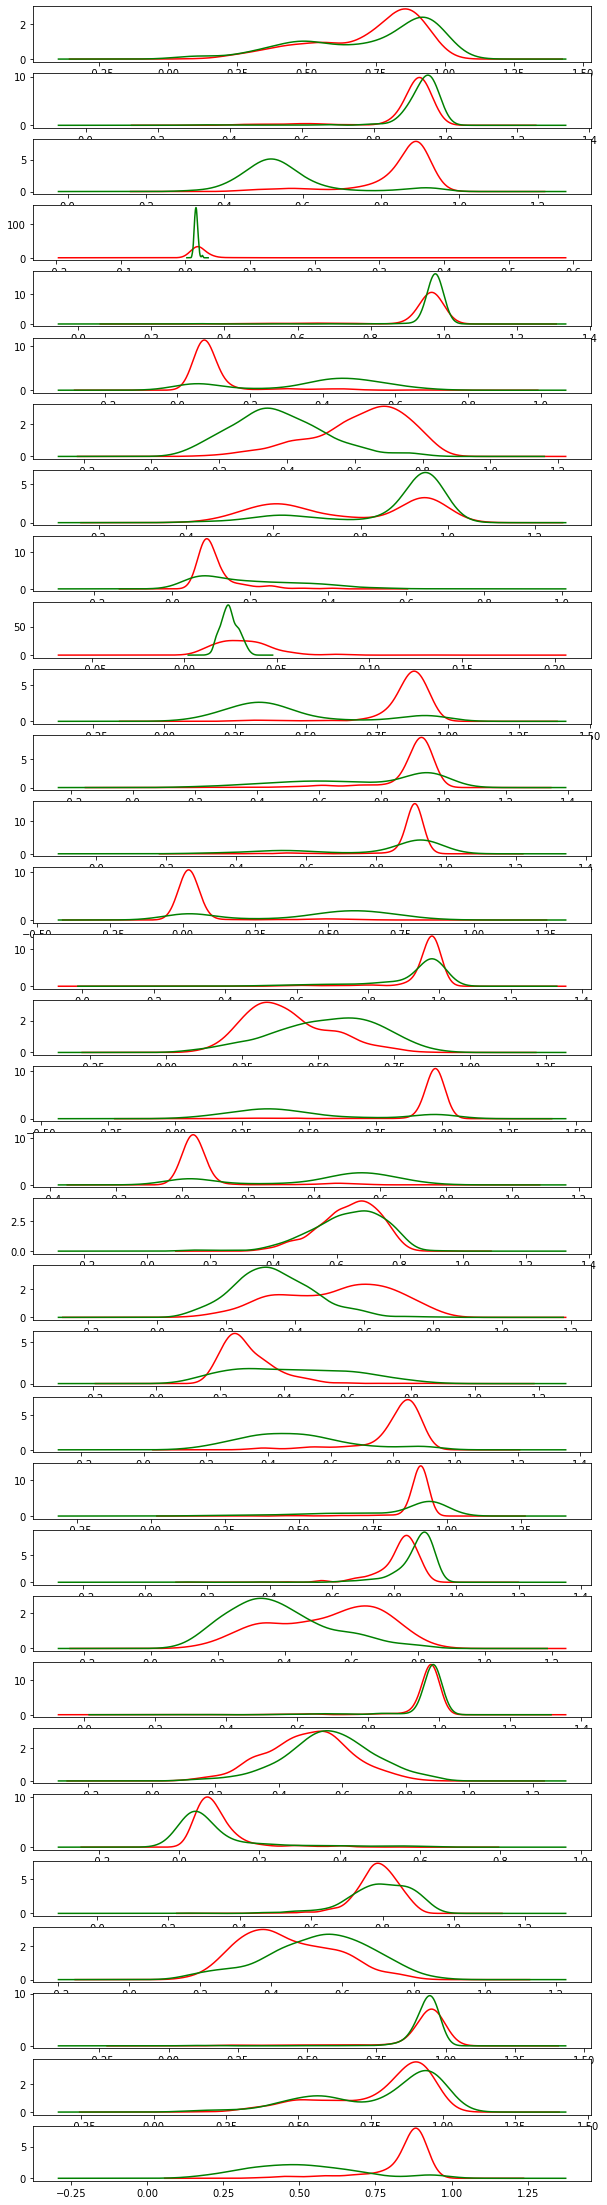

In [83]:
fig, ax = plt.subplots(nrows=len(Corrected_top), figsize=(10,40))
for i, probeid in enumerate(Corrected_top):
    Meth_data_T['LA'][Corrected_top[i]].plot.kde(color='red', ax=ax[i])
    Meth_data_T['LSCC'][Corrected_top[i]].plot.kde(color='green', ax=ax[i])
    ax[i].set_ylabel('')
    #ax[i].set_title(probeid)

In [97]:
FDR_top20 = top_probes['FDR'][:20].index.tolist()
KS_top20 = top_probes['KS'][:20].index.tolist()
MWU_top20 = top_probes['MWU'][:20].index.tolist()
#AD_top20 = top_probes['AD'][:20].index.tolist()
WASS1_top20 = top_probes['WASS1'][:20].index.tolist()
WASS2_top20 = top_probes['WASS2'][:20].index.tolist()
LDA_top20 = LDA_scores.abs().sort_values(by='LDA_score', ascending=False)[:20].index.tolist()

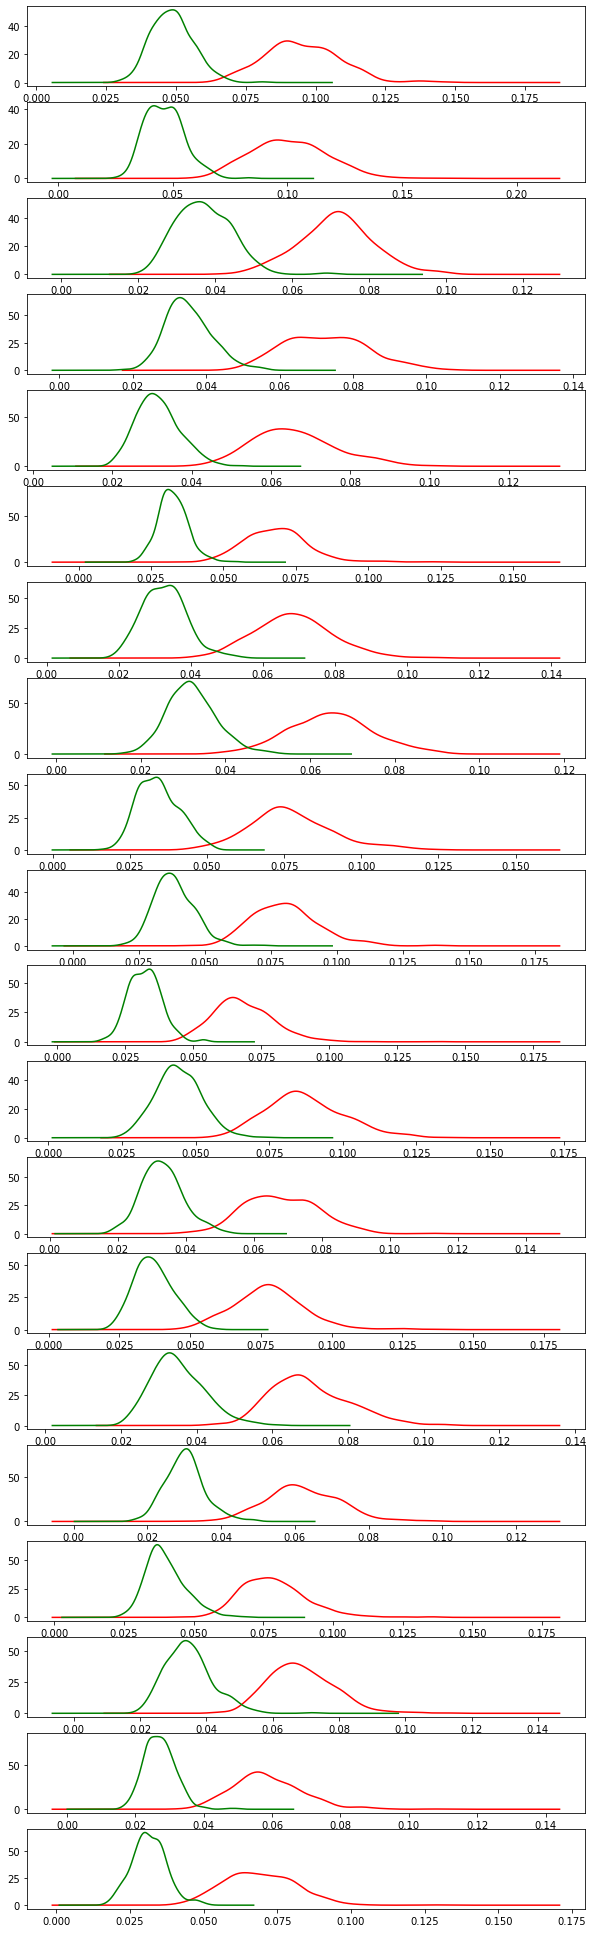

In [78]:
fig, ax = plt.subplots(nrows=len(FDR_top20), figsize=(10,35))
for i, probeid in enumerate(FDR_top20):
    Meth_data_T['LA'][probeid].plot.kde(color='red', ax=ax[i])
    Meth_data_T['LSCC'][probeid].plot.kde(color='green', ax=ax[i])
    ax[i].set_ylabel('')
    #ax[i].set_title(probeid)

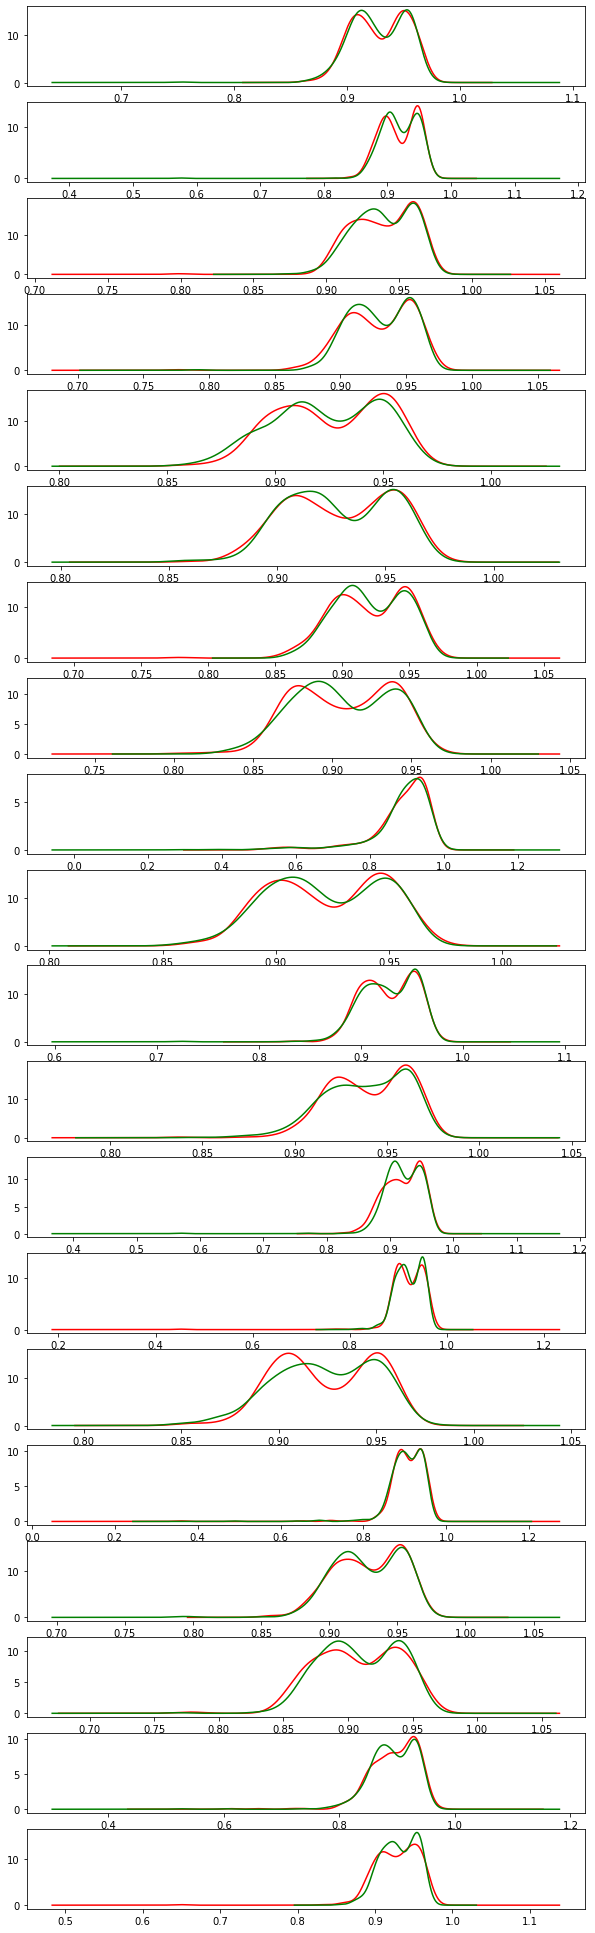

In [89]:
fig, ax = plt.subplots(nrows=len(MWU_top20), figsize=(10,35))
for i, probeid in enumerate(MWU_top20):
    _cleaned_ALL.iloc[np.where(y==1)][probeid].plot.kde(color='red', ax=ax[i])
    _cleaned_ALL.iloc[np.where(y==0)][probeid].plot.kde(color='green', ax=ax[i])
    ax[i].set_ylabel('')
    #ax[i].set_title(probeid)

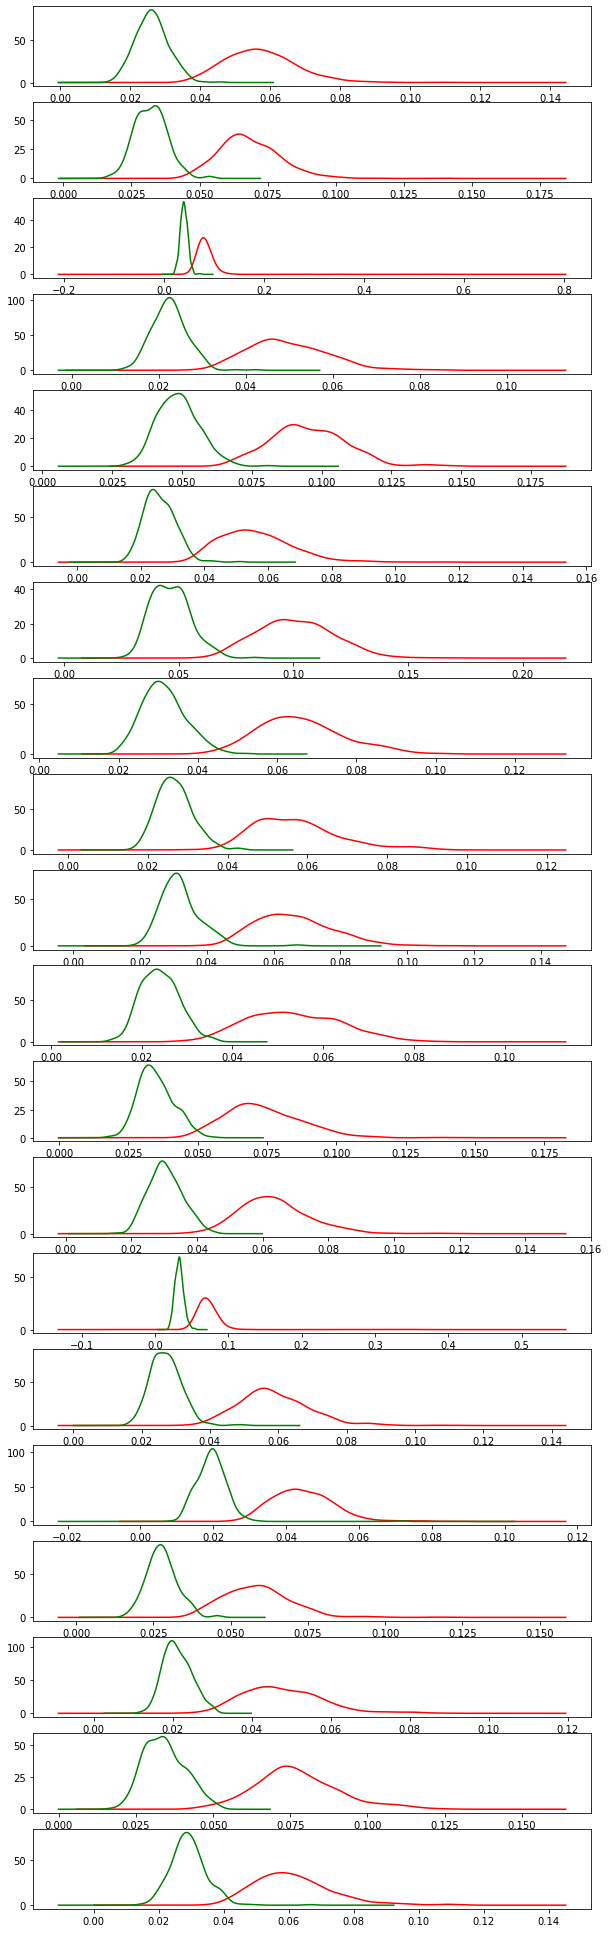

In [80]:
fig, ax = plt.subplots(nrows=len(KS_top20), figsize=(10,35))
for i, probeid in enumerate(KS_top20):
    Meth_data_T['LA'][probeid].plot.kde(color='red', ax=ax[i])
    Meth_data_T['LSCC'][probeid].plot.kde(color='green', ax=ax[i])
    ax[i].set_ylabel('')
    #ax[i].set_title(probeid)

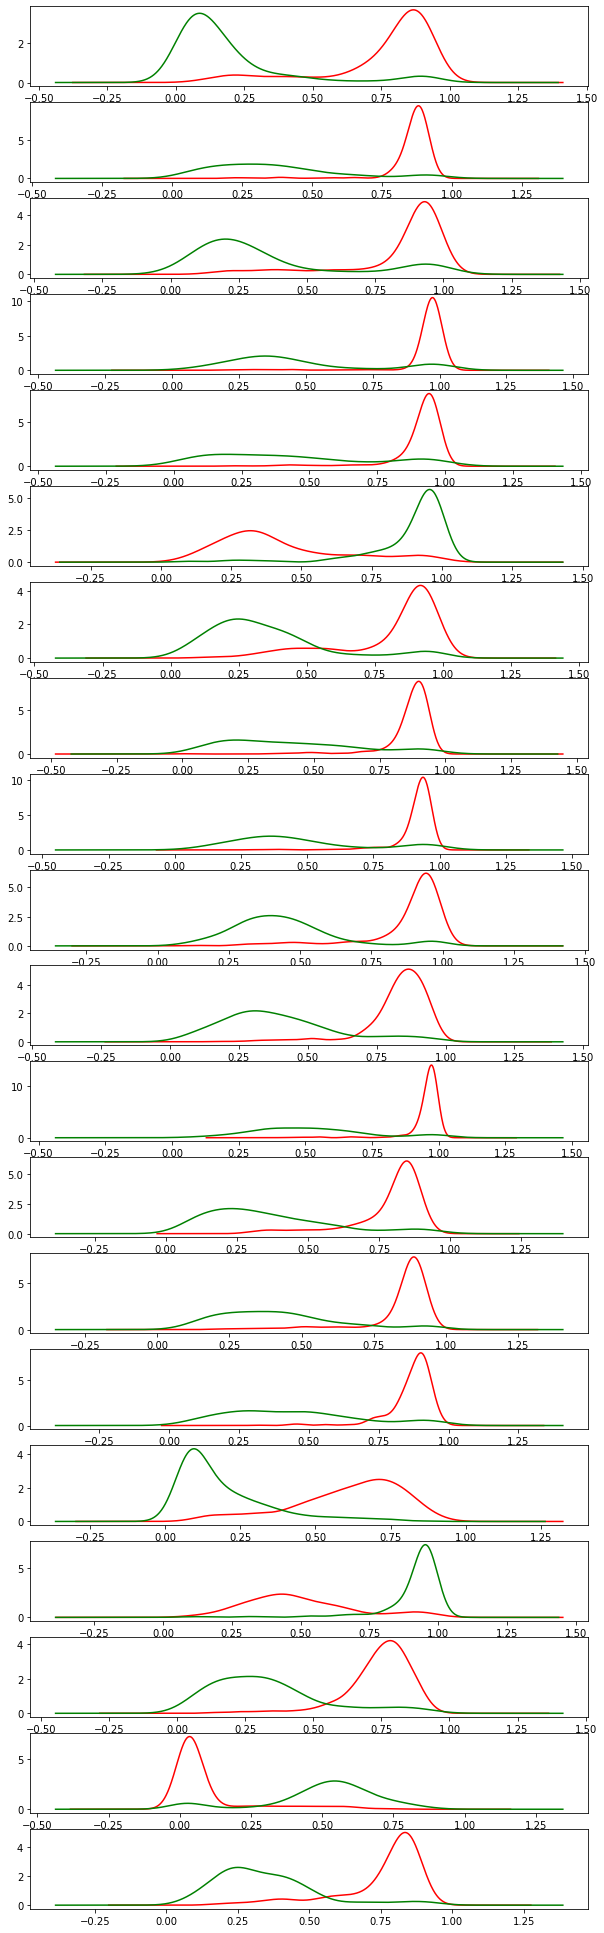

In [81]:
fig, ax = plt.subplots(nrows=len(WASS1_top20), figsize=(10,35))
for i, probeid in enumerate(WASS1_top20):
    Meth_data_T['LA'][probeid].plot.kde(color='red', ax=ax[i])
    Meth_data_T['LSCC'][probeid].plot.kde(color='green', ax=ax[i])
    ax[i].set_ylabel('')
    #ax[i].set_title(probeid)

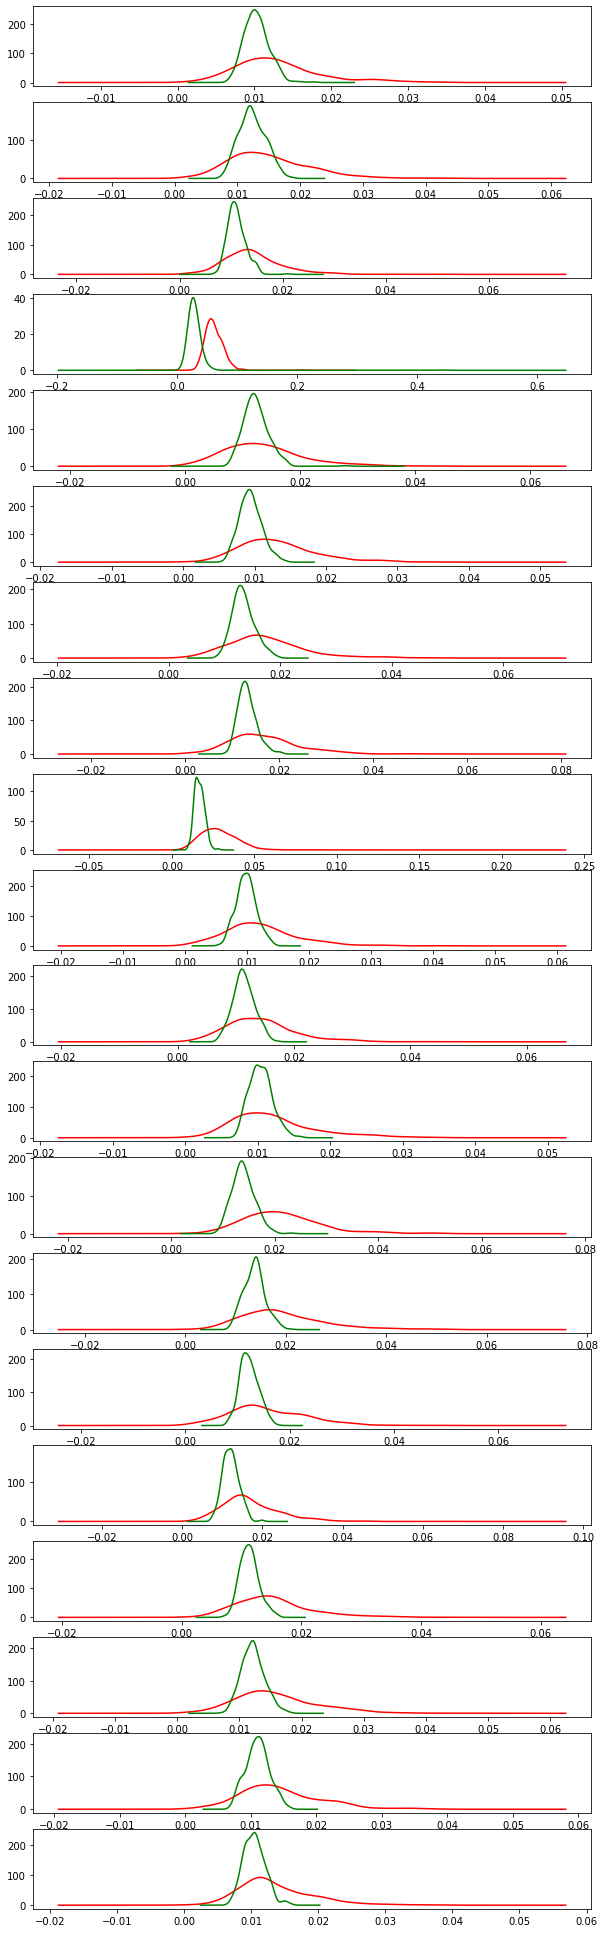

In [98]:
fig, ax = plt.subplots(nrows=len(LDA_top20), figsize=(10,35))
for i, probeid in enumerate(LDA_top20):
    Meth_data_T['LA'][probeid].plot.kde(color='red', ax=ax[i])
    Meth_data_T['LSCC'][probeid].plot.kde(color='green', ax=ax[i])
    ax[i].set_ylabel('')
    #ax[i].set_title(probeid)

## Get overlap of top-probes

In [138]:
#for _key in probes_diffs.keys():
#    probes_diffs[_key].columns = ['pvals_'+_key, 'score_'+_key]

## Only the overlap of the top-20000 probes
ppset= None
topM = 50000
for idx, _key in enumerate(probes_diffs.keys()):
    if _key in ['AD', 'WASS2']:
        break
    else:
        # query('pvals_'+_key+'<0.001')
        pset = (set(probes_diffs[_key].sort_values(by='score', ascending=False)[:topM].index.tolist()))
        if idx>0:
            ppset = pset.intersection(ppset)
        else:
            ppset = pset
ppset = list(ppset)

tot_overlap = probes_diffs['FDR'].merge(probes_diffs['KS'], 
                              how='inner', 
                              left_index=True, 
                              right_index=True, 
                              suffixes=['_FDR', '_KS'])
tot_overlap = tot_overlap.copy().merge(probes_diffs['MWU'].rename(index=str, columns={'pvals': 'pvals_MWU', 'score': 'score_MWU'}), 
                              how='inner', 
                              left_index=True, 
                              right_index=True)
tot_overlap = tot_overlap.copy().merge(probes_diffs['WASS1'].rename(index=str, columns={'score': 'score_WASS1'}), 
                              how='inner', 
                              left_index=True, 
                              right_index=True)
tot_overlap = tot_overlap.loc[ppset]
tot_overlap = tot_overlap.copy().merge(fc, left_index=True, right_index=True, how='inner')
tot_overlap = tot_overlap.copy().merge(GeneMapping, left_index=True, right_index=True, how='inner')
#tot_overlap['score_WASS1'] = tot_overlap['pvals_WASS1']
#tot_overlap.drop(['pvals', 'pvals_WASS1', 'pvals_WASS2', 'score_WASS2'], axis=1, inplace=True)
print(tot_overlap.shape)
gc.collect()
tot_overlap.sort_values('score_WASS1', ascending=False, inplace=True)
tot_overlap.to_csv('/media/koekiemonster/DATA-FAST/genetic_expression/hackathon_2/Lung/_results/top_methyl_overlap_noPval.csv',
          sep=';')

(108, 16)


In [147]:
tot = probes_diffs['FDR'].merge(probes_diffs['KS'], 
                              how='inner', 
                              left_index=True, 
                              right_index=True, 
                              suffixes=['_FDR', '_KS'])
tot = tot.copy().merge(probes_diffs['MWU'].rename(index=str, columns={'pvals': 'pvals_MWU', 'score': 'score_MWU'}), 
                              how='inner', 
                              left_index=True, 
                              right_index=True)
tot = tot.copy().merge(probes_diffs['WASS1'].rename(index=str, columns={'score': 'score_WASS1'}), 
                              how='inner', 
                              left_index=True, 
                              right_index=True)
tot = tot.copy().merge(fc, left_index=True, right_index=True, how='inner')
tot = tot.copy().merge(GeneMapping, left_index=True, right_index=True, how='inner')
gc.collect()

81648

In [139]:
## Only the non-mutual set of top-N probes 
ppset= None
topM = 100
for idx, _key in enumerate(probes_diffs.keys()):
    if _key in ['AD', 'WASS2']:
        break
    else:
        # query('pvals_'+_key+'<0.001')
        pset = (set(probes_diffs[_key].sort_values(by='score', ascending=False)[:topM].index.tolist()))
        if idx>0:
            ppset = pset.union(ppset)
        else:
            ppset = pset
ppset = list(ppset)

tot_exclusive = probes_diffs['FDR'].merge(probes_diffs['KS'], 
                              how='inner', 
                              left_index=True, 
                              right_index=True, 
                              suffixes=['_FDR', '_KS'])
tot_exclusive = tot_exclusive.copy().merge(probes_diffs['MWU'].rename(index=str, columns={'pvals': 'pvals_MWU', 'score': 'score_MWU'}), 
                              how='inner', 
                              left_index=True, 
                              right_index=True)
tot_exclusive = tot_exclusive.copy().merge(probes_diffs['WASS1'].rename(index=str, columns={'score': 'score_WASS1'}), 
                              how='inner', 
                              left_index=True, 
                              right_index=True)
tot_exclusive = tot_exclusive.loc[ppset]
tot_exclusive = tot_exclusive.copy().merge(fc, left_index=True, right_index=True, how='inner')
tot_exclusive = tot_exclusive.copy().merge(GeneMapping, left_index=True, right_index=True, how='inner')
#tot_exclusive.drop(['pvals', 'pvals_WASS1', 'pvals_WASS2', 'score_WASS2'], axis=1, inplace=True)
print(tot_exclusive.shape)
gc.collect()
tot_exclusive.sort_values('score_WASS1', ascending=False, inplace=True)
tot_exclusive.to_csv('/media/koekiemonster/DATA-FAST/genetic_expression/hackathon_2/Lung/_results/top_methyl_exclusive_noPval.csv',
          sep=';')

(375, 16)


In [149]:
top_N = 500
topD = fc.sort_values(by='abs_fc_median', ascending=False)[:top_N]
topA = fc.sort_values(by='abs_fc_median', ascending=True)[:top_N]
topFC = pd.concat([topD, topA], axis=0)
topFC = topFC.copy().merge(tot, how='inner', left_index=True, right_index=True)

#topFC.drop('score_y', axis=1, inplace=True)
#topFC.rename(index=str, columns={'score_x': 'score_Wass1'}, inplace=True)
topFC.to_csv('/media/koekiemonster/DATA-FAST/genetic_expression/hackathon_2/Lung/_results/top_fc.csv',
          sep=';')

In [ ]:
fc_all = fc.copy().merge(tot, how='inner', left_index=True, right_index=True)
all_fc.to_csv('/media/koekiemonster/DATA-FAST/genetic_expression/hackathon_2/Lung/_results/all_fc.csv',
          sep=';')

In [150]:
top_N = 100
topD = LDA_scores.sort_values(by='LDA_score', ascending=False)[:top_N]
topA = LDA_scores.sort_values(by='LDA_score', ascending=True)[:top_N]
topLDA = pd.concat([topD, topA], axis=0)
topLDA = topLDA.copy().merge(tot, how='inner', left_index=True, right_index=True)

#topFC.drop('score_y', axis=1, inplace=True)
#topFC.rename(index=str, columns={'score_x': 'score_Wass1'}, inplace=True)
topLDA.to_csv('/media/koekiemonster/DATA-FAST/genetic_expression/hackathon_2/Lung/_results/top_lda.csv',
          sep=';')

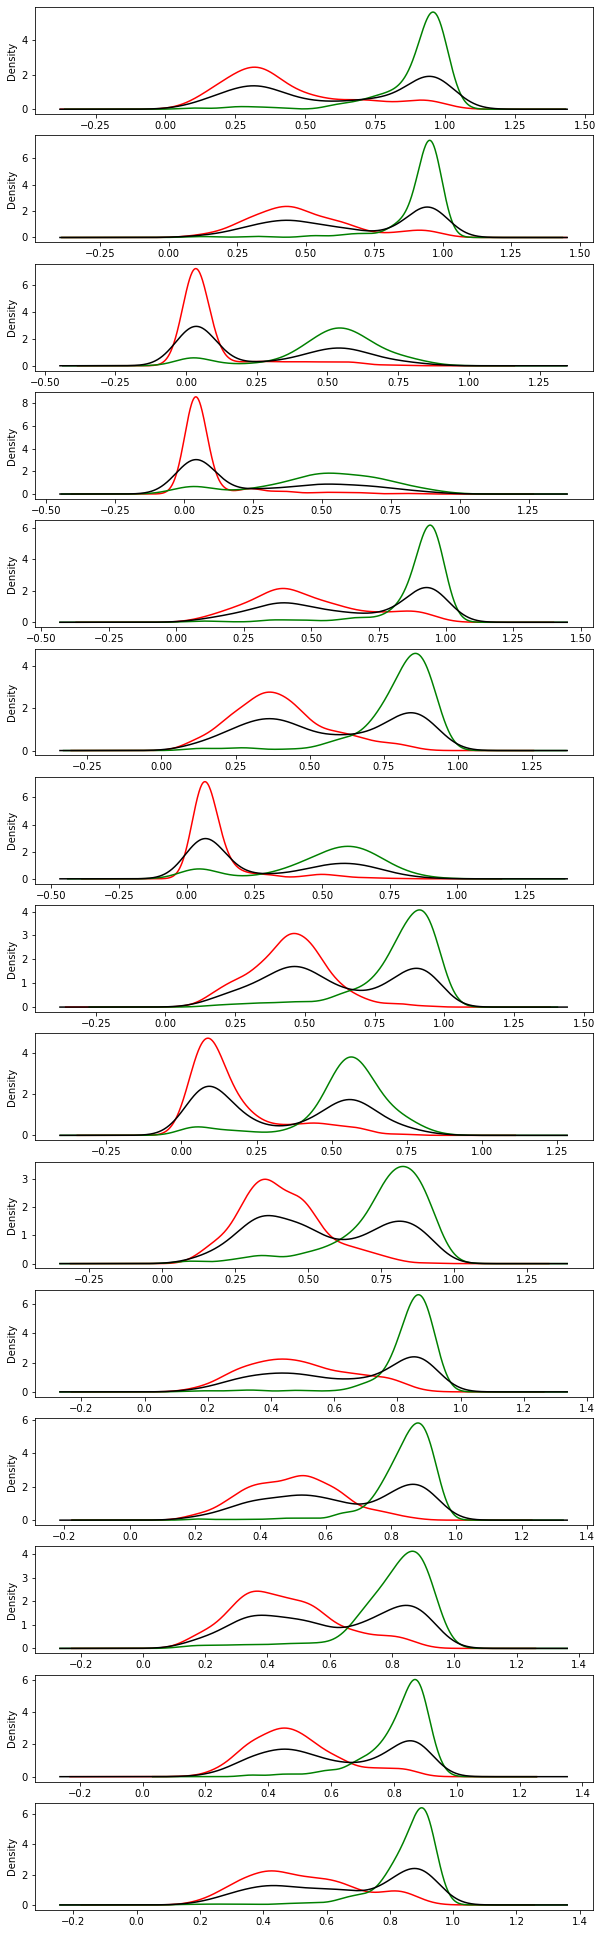

In [143]:
M = 15
fig, ax = plt.subplots(nrows=M, figsize=(10,35))
for i, probeid in enumerate(tot_overlap.index.tolist()[:M]):
    Meth_data_T['LA'][probeid].plot.kde(color='red', ax=ax[i])
    Meth_data_T['LSCC'][probeid].plot.kde(color='green', ax=ax[i])
    _cleaned_ALL[probeid].plot.kde(color='black', ax=ax[i])
    #ax[i].set_ylabel('')
    #ax[i].set_title(probeid)

## Unsupervised search for multi-modality

In [152]:
from unidip import UniDip
# Use Hartigan's dip test recursively
num_modes = []
cols = _cleaned_ALL.columns

n_procs = 10
pool = multiprocessing.Pool(n_procs)

def get_dips(i):
    _col = cols[i]
    dat = _cleaned_ALL[_col].sort_values()
    intervals = UniDip(dat, alpha=0.05, ntrials=50, mrg_dst=5).run()
    return {'probe': _col, 'num_modes': len(intervals)}

num_modes_df = pd.DataFrame(pool.map(get_dips, range(0, len(cols))))
num_modes_df.set_index('probe', inplace=True)

Process ForkPoolWorker-34:
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Process ForkPoolWorker-31:
Process ForkPoolWorker-33:
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-37:
Process ForkPoolWorker-32:
Process ForkPoolWorker-39:
Process ForkPoolWorker-38:
Process ForkPoolWorker-40:
Process ForkPoolWorker-35:
Traceback (most recent call last):
Process ForkPoolWorker-36:
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **sel

In [166]:
multi_mod_probs = {}
multi_mod_probs['1'] = num_modes_df[num_modes_df.num_modes==1].index.tolist()
multi_mod_probs['2'] = num_modes_df[num_modes_df.num_modes==2].index.tolist()
multi_mod_probs['3'] = num_modes_df[num_modes_df.num_modes==3].index.tolist()
multi_mod_probs['4'] = num_modes_df[num_modes_df.num_modes==4].index.tolist()
multi_mod_probs['5'] = num_modes_df[num_modes_df.num_modes==5].index.tolist()
multi_mod_probs['6'] = num_modes_df[num_modes_df.num_modes==6].index.tolist()
multi_mod_probs['7'] = num_modes_df[num_modes_df.num_modes==7].index.tolist()

Gene Chr                                chrX
Start                       4.65454e+07
Stop                        4.65454e+07
Strand                                -
Gene                   ZNF674,LOC401588
Relation_CpG_Island                 NaN
Name: cg00115511, dtype: object 

Not in index for tot_overlap :( 

Not in index for tot_exclusive :( 

Not in index for top fc :( 

pvals_FDR    0.958626
score_FDR    0.002693
Name: cg00115511, dtype: float64 

pvals_KS    0.879285
score_KS    0.039423
Name: cg00115511, dtype: float64 

pvals_MWU        0.980019
score_MWU    91663.000000
Name: cg00115511, dtype: float64 

pvals_WASS1    0.005841
score_WASS1    0.005841
pvals               NaN
Name: cg00115511, dtype: float64 



Text(0.5, 1.0, 'cg00115511')

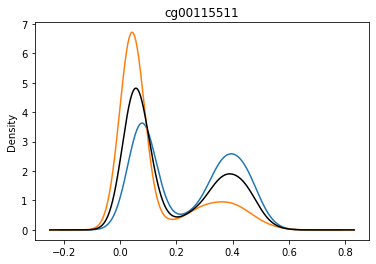

In [249]:
l = '4'
k = 1

print("Gene", GeneMapping.loc[multi_mod_probs[l][k]], "\n")

try: 
    tot_overlap.loc[multi_mod_probs[l][k]]
except KeyError as e:
    print("Not in index for tot_overlap :( \n")
    
try: 
    tot_exclusive.loc[multi_mod_probs[l][k]]
except KeyError as e:
    print("Not in index for tot_exclusive :( \n")
    
try: 
    top_fc.loc[multi_mod_probs[l][k]]
except KeyError as e:
    print("Not in index for top fc :( \n")
    
print(probes_diffs['FDR'].loc[multi_mod_probs[l][k]], "\n")
print(probes_diffs['KS'].loc[multi_mod_probs[l][k]], "\n")
print(probes_diffs['MWU'].loc[multi_mod_probs[l][k]], "\n")
print(probes_diffs['WASS1'].loc[multi_mod_probs[l][k]], "\n")

Meth_data_T['LA'].loc[:, multi_mod_probs[l][k]].plot.kde()
Meth_data_T['LSCC'].loc[:, multi_mod_probs[l][k]].plot.kde()
_cleaned_ALL.loc[:, multi_mod_probs[l][k]].plot.kde(color='black')
plt.title(multi_mod_probs[l][k])

With the knowledge of multi-modality per dimension we can effectively filter out the noise to effectively perform unsupervised clustering. 

```
cg00006626, NUP210L
cg00001582, ZMIZ1,LOC283050
cg00012036, H3F3B
cg00087098, G3BP2
cg00611101, TCEAL2
...
etc..
```

A benefit of this multi-modality search is the robustness in case of non-Gaussian, or non-standard distributions. 
How to find those probes that **do** seperate the targets but do not fulfill the prerequisites for the unpaired tests?

* Multimodality -> paired samples comparison between groups, compared to sample comparison within group
* apply supervised learner: LR(Bayesian), RF (random), XGB (gradient boosted), EBM (generalised additive model)

## Top differential RNA expression
* KRT5 
* DSC3
* DSG3
* TP63
* MIR205HG
* CALML3

What are the corresponding probevalues? What are the methylation fold changes?

## Supervised learner

In [152]:
from sklearn.linear_model import LogisticRegressionCV as LR
from sklearn.ensemble import ExtraTreesClassifier as ET
from sklearn.ensemble import RandomForestClassifier as RF
from xgboost import XGBClassifier as XGB
from lightgbm import LGBMClassifier as LGBM
from interpret.glassbox import ExplainableBoostingClassifier as EB

In [206]:
# impose some filters 
# * minimum abs fold change of 0.1 (beta)
filter_1 = fc.loc[(fc.abs_fc>0.1) | (fc.abs_fc<-0.1)].index.tolist() 
x_filtered = x.loc[:, filter_1]

In [252]:
# vanilla
mod_LR = LR(n_jobs=4)
mod_ET = ET(n_estimators=7500, n_jobs=4)
mod_RF = RF(n_estimators=7500, n_jobs=4)
mod_XGB = XGB(n_estimators=500, n_jobs=4)
#mod_LGBM = LGBM(n_estimators=150, n_jobs=4)
#mod_EB = EB(n_estimators=32, n_jobs=4)

#cols = np.array(x.columns.tolist())
#lr_coefs = mod_LR.coef_.reshape([-1,1])[:,0]

In [210]:
gc.collect()
mod_LR.fit(x_filtered,y)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2053: FutureWarning:

You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning:

lbfgs failed to converge. Increase the number of iterations.



LogisticRegressionCV(Cs=10, class_weight=None, cv='warn', dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='warn', n_jobs=4, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [254]:
gc.collect()
mod_ET.fit(x_filtered,y)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=5000, n_jobs=4,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [255]:
gc.collect()
mod_RF.fit(x_filtered,y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=5000, n_jobs=4,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [256]:
gc.collect()
mod_XGB.fit(x_filtered,y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=4, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [214]:
# extract importances
coefs_LR =pd.DataFrame(data=mod_LR.coef_.reshape([-1,1]), index=x_filtered.columns, columns=['LR_coeff'])

In [257]:
coefs_RF = pd.DataFrame(data=mod_RF.feature_importances_, index=x_filtered.columns,columns=['RF_importance'])

In [258]:
coefs_ET = pd.DataFrame(data=mod_ET.feature_importances_, index=x_filtered.columns,columns=['ET_importance'])

In [259]:
coefs_XGB = pd.DataFrame(data=mod_XGB.feature_importances_, index=x_filtered.columns,columns=['XGB_importance'])

In [260]:
comb = pd.concat([coefs_LR, coefs_RF, coefs_ET, coefs_XGB], axis=1)
comb.sort_values(by='XGB_importance', ascending=False, inplace=True)
comb = comb.copy().merge(tot, how='left', left_index=True, right_index=True)
comb.to_csv('/media/koekiemonster/DATA-FAST/genetic_expression/hackathon_2/Lung/_results/all_res_min01FC.csv',
          sep=';')
gc.collect()

55

In [31]:
splt = fc[['abs_fc_median', 'split_fc']].reset_index()
tmp=pd.DataFrame(data=x[y==0].std(axis=0), columns=['std_LA'])
splt = splt.copy().merge(tmp, how='inner', left_on='index', right_index=True)
tmp=pd.DataFrame(data=x[y==1].std(axis=0), columns=['std_LSCC'])
splt = splt.copy().merge(tmp, how='inner', left_on='index', right_index=True)
splt['adapted_fold_change'] = 2*splt.abs_fc_median/(splt.std_LA+splt.std_LSCC) # correct for large std's
# you can introduce the effect of Kurtosis and Skewness as well.

In [32]:
def super_simple_model(x, y, splt, min_lscc=0.75, min_la=0.75, max_consecutive_fail=50, adapted_sort=False):
    # not optimized, super slow
    rnk_var = 'adapted_fold_change' if adapted_sort else 'fold_change_median'
    splt = splt.copy().reindex(splt[rnk_var].abs().sort_values(ascending=False).index)
    
    x_train = x.copy()
    x_train['y'] = y
    
    fail = 0 
    rules = []
    for row in splt.iterrows():
        split_gen = row[1]['index']
        fc_split =row[1]['split_fc']
        v1 = x_train.loc[x[split_gen]<fc_split].y.mean()
        v2 = x_train.loc[x[split_gen]>fc_split].y.mean()

        acc_lscc = np.max([v1, v2])
        acc_la = np.max([1-v1,1-v2])
        if (acc_lscc>min_lscc) and (acc_la>min_la):
            rules.append({'acc_lscc': acc_lscc, 'acc_la': acc_la, 'split' : fc_split, 'dim': split_gen, 'sign': v2>v1})
            fail=0
        else:
            fail+=1
        if (fail>max_consecutive_fail) and (max_consecutive_fail!=-1) and (max_consecutive_fail is not None):
            return pd.DataFrame(rules)
    return pd.DataFrame(rules)

In [34]:
split_genes = super_simple_model(x, y, splt, min_lscc=0.8, min_la=0.8, max_consecutive_fail=50, adapted_sort=True);
split_genes.set_index('dim', inplace=True)

KeyboardInterrupt: 

In [ ]:
#split_genes = split_genes.copy().merge(score_list_all['raw'], how='left', left_index=True, right_index=True)
split_genes.rename(index=str, columns={'sign': 'lscc_on_the_rightside_of_split'}, inplace=True)

In [25]:
# merge with tot
fc = fc.copy().merge(GeneMapping, how='left', left_index=True, right_index=True) # tot
split_genes = split_genes.copy().merge(fc, how='left', left_index=True, right_index=True)

In [ ]:
split_genes.to_csv("/media/koekiemonster/DATA-FAST/genetic_expression/hackathon_2/Lung/_results/best_splits_methylation.csv", sep=";")

In [ ]:
fc.to_csv("/media/koekiemonster/DATA-FAST/genetic_expression/hackathon_2/Lung/_results/fc_all_methylation.csv", sep=";")

## Paired testing

In [1]:
# paired test
# KLD
from scipy.special import kl_div
from scipy.special import rel_entr


## Paired comparison -> probewise
i.e. per sample we have a vector of probe values 
For each target group we have a different set of probe value vectors. 

This type of analysis can provide us with sample clusters that may be predictive of target groups.

Typical methods are: KLD, JSD, spatial distance (abs cosine, spearman, pearson, euclidean..)

## Unpaired comparison -> sample wise
i.e. per probe we have vector sample values. 

This type of analysis can provide us with some metric that describes how well the target groups are seperated per probe.

Typical methods are: KS, MWU, Wasserstein, FDR, FPR 

# Key results

* top differential methylation probes and corresponding genes
* list of fold changes -> write to file